## CSC 275 - Final Project: **Deep Learning Indoor Localization Based on Wi-Fi RSS Dataset**
---
#### Location fingerprinting using received signal strengths (RSSs) from wireless network infrastructure is one of the most popular and promising technologies for localization in an indoor environment, where there is no line-of-sight signal from the global positioning system (GPS) available. 

#### We implement Deep Neural Network Models using a vector of pairs of a service set identifier (SSID) and an RSS for a Wi-Fi access point (AP) measured at a location can be its location fingerprint. A location of a user/device then can be estimated by finding the closest match between its RSS measurement and the fingerprints of known locations in a database. 
---
##### Team Members: Anser Parvez Nadvi (301617706), Azhar Chara (301617576), & Tejal Bijwe ()

### **Importing all Required Libraries**


In [ ]:
# Importing necessary Libraries
import os
import numpy as np
import pandas as pd
import time
import io
import requests
import json
import csv
import pprint
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
import seaborn as sns
import collections
import shutil
import pickle


from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import r2_score
import sklearn.feature_extraction.text as tfidf
from sklearn import datasets,linear_model, preprocessing,utils
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA 
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.sparse import lil_matrix
from scipy.stats import zscore


import tensorflow as tf
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import *
from keras.layers.core import Dense, Activation, Flatten
from keras import optimizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv1D, Conv2D, MaxPooling2D

In [ ]:
pip install SciencePlots

  Created wheel for SciencePlots: filename=SciencePlots-1.0.6-cp36-none-any.whl size=4140 sha256=416bdc379a72b573826b3a8645c28911362a09a07f841507f4d86e10503db119
  Stored in directory: /root/.cache/pip/wheels/66/f8/97/c4d1f89a613feb90268bf62b192c3038e87e453d6d36b7726c
Successfully built SciencePlots


### **Defining functions for Plotting & Data Pre-Processing**

In [ ]:
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.

def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()    

def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32, np.object):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
    
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
  
def to_sequences(seq_size, data1, data2):
    x = []    
    y = []
    for i in range(len(data1)-seq_size):
        #print(i)
        window = data1[i:(i+seq_size)]
        after_window = data2[i+seq_size]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)        
    return np.array(x), np.array(y)

### **Data Pre-Processing**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Azhar Drive location
# train_data = pd.read_csv("drive/My Drive/UJLoc/trainingData2.csv")

# Parvez Drive location
train_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/trainingData2.csv")

In [ ]:
# Dataset shape
train_data.shape

(19937, 529)

In [ ]:
train_data.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,WAP011,WAP012,WAP013,WAP014,WAP015,WAP016,WAP017,WAP018,WAP019,WAP020,WAP021,WAP022,WAP023,WAP024,WAP025,WAP026,WAP027,WAP028,WAP029,WAP030,WAP031,WAP032,WAP033,WAP034,WAP035,WAP036,WAP037,WAP038,WAP039,WAP040,...,WAP490,WAP491,WAP492,WAP493,WAP494,WAP495,WAP496,WAP497,WAP498,WAP499,WAP500,WAP501,WAP502,WAP503,WAP504,WAP505,WAP506,WAP507,WAP508,WAP509,WAP510,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,...,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,...,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,-110,-110,-110,-110,-110,-110,-110,-97,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,...,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-92,-110,-110,-110,-110,-110,...,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,...,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


In [ ]:
# Datatypes in the dataset
list(train_data.dtypes)

[dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'

In [ ]:
# Number of unique spaces in the dataset
print(sorted(train_data['SPACEID'].unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 25, 26, 27, 28, 29, 30, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 253, 254]


In [ ]:
# Space distribution
from collections import Counter
print(Counter(train_data['SPACEID']))

Counter({202: 484, 106: 475, 107: 469, 104: 439, 102: 418, 101: 418, 201: 418, 103: 415, 108: 385, 105: 366, 203: 348, 110: 334, 122: 318, 112: 318, 111: 318, 140: 308, 129: 296, 126: 296, 128: 293, 109: 291, 113: 289, 206: 288, 121: 275, 125: 265, 127: 264, 120: 263, 117: 261, 118: 261, 124: 260, 119: 258, 136: 257, 204: 256, 216: 254, 214: 250, 130: 243, 133: 239, 114: 234, 115: 229, 207: 217, 132: 217, 217: 216, 208: 214, 116: 211, 205: 210, 134: 206, 209: 204, 139: 200, 224: 193, 218: 178, 137: 174, 211: 169, 222: 169, 210: 167, 131: 167, 123: 166, 212: 159, 215: 157, 135: 157, 138: 152, 219: 148, 220: 141, 143: 140, 213: 139, 225: 129, 230: 129, 223: 125, 235: 121, 229: 118, 227: 118, 248: 110, 231: 110, 226: 108, 247: 100, 221: 100, 228: 99, 234: 99, 3: 97, 4: 95, 10: 89, 141: 86, 2: 80, 236: 80, 237: 80, 6: 79, 244: 70, 1: 65, 5: 60, 9: 60, 233: 60, 238: 59, 8: 56, 241: 55, 243: 49, 16: 42, 246: 40, 245: 40, 239: 40, 232: 39, 13: 39, 7: 38, 15: 30, 242: 30, 249: 30, 17: 24, 26: 

In [ ]:
print(list(train_data))

['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006', 'WAP007', 'WAP008', 'WAP009', 'WAP010', 'WAP011', 'WAP012', 'WAP013', 'WAP014', 'WAP015', 'WAP016', 'WAP017', 'WAP018', 'WAP019', 'WAP020', 'WAP021', 'WAP022', 'WAP023', 'WAP024', 'WAP025', 'WAP026', 'WAP027', 'WAP028', 'WAP029', 'WAP030', 'WAP031', 'WAP032', 'WAP033', 'WAP034', 'WAP035', 'WAP036', 'WAP037', 'WAP038', 'WAP039', 'WAP040', 'WAP041', 'WAP042', 'WAP043', 'WAP044', 'WAP045', 'WAP046', 'WAP047', 'WAP048', 'WAP049', 'WAP050', 'WAP051', 'WAP052', 'WAP053', 'WAP054', 'WAP055', 'WAP056', 'WAP057', 'WAP058', 'WAP059', 'WAP060', 'WAP061', 'WAP062', 'WAP063', 'WAP064', 'WAP065', 'WAP066', 'WAP067', 'WAP068', 'WAP069', 'WAP070', 'WAP071', 'WAP072', 'WAP073', 'WAP074', 'WAP075', 'WAP076', 'WAP077', 'WAP078', 'WAP079', 'WAP080', 'WAP081', 'WAP082', 'WAP083', 'WAP084', 'WAP085', 'WAP086', 'WAP087', 'WAP088', 'WAP089', 'WAP090', 'WAP091', 'WAP092', 'WAP093', 'WAP094', 'WAP095', 'WAP096', 'WAP097', 'WAP098', 'WAP099', 'WAP100',

In [ ]:
train_data.columns

Index(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006', 'WAP007',
       'WAP008', 'WAP009', 'WAP010',
       ...
       'WAP520', 'LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID', 'SPACEID',
       'RELATIVEPOSITION', 'USERID', 'PHONEID', 'TIMESTAMP'],
      dtype='object', length=529)

In [ ]:
feature_list = list(train_data)

In [ ]:
#Drop unneeded data
train_data.drop(['USERID', 'PHONEID', 'TIMESTAMP'], axis = 1, inplace=True)

#Remove "NaN" value
col = train_data.columns[0:520]
for i in col:
    train_data[i].fillna(0, inplace=True)
    
train_data.dropna(subset=['LONGITUDE','LATITUDE', 'FLOOR', 'BUILDINGID' ], inplace=True)
#trainingData.isnull().sum()



#Process "WAP" data
train_data.iloc[:, 0:520] = np.where(train_data.iloc[:, 0:520] <= 0, 
                        train_data.iloc[:, 0:520] + 105, 
                        train_data.iloc[:, 0:520] - 100)

#Process Longtitude
train_data.iloc[:, 520] = np.where(train_data.iloc[:, 520] <= 0, 
                        -train_data.iloc[:, 520], 
                        train_data.iloc[:, 520])


train_data.describe()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,WAP011,WAP012,WAP013,WAP014,WAP015,WAP016,WAP017,WAP018,WAP019,WAP020,WAP021,WAP022,WAP023,WAP024,WAP025,WAP026,WAP027,WAP028,WAP029,WAP030,WAP031,WAP032,WAP033,WAP034,WAP035,WAP036,WAP037,WAP038,WAP039,WAP040,...,WAP487,WAP488,WAP489,WAP490,WAP491,WAP492,WAP493,WAP494,WAP495,WAP496,WAP497,WAP498,WAP499,WAP500,WAP501,WAP502,WAP503,WAP504,WAP505,WAP506,WAP507,WAP508,WAP509,WAP510,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION
count,19937.000000,19937.000000,19937.0,19937.0,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,...,19937.0,19937.0,19937.000000,19937.000000,19937.0,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.0,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.0,19937.000000,1.993700e+04,19937.000000,19937.000000,19937.000000,19937.000000
mean,-4.986758,-4.978934,-5.0,-5.0,-4.964940,-4.625320,-4.178161,-4.048804,-4.038822,-4.919848,0.280684,0.319657,-1.401364,-1.448262,-3.775944,-3.850278,-4.915233,-4.907559,-4.270602,-4.314892,-4.970708,-4.970206,-3.729347,-3.721272,-3.979887,-3.946381,-3.730451,-3.672368,-2.117520,-2.069218,-3.907609,-3.898179,-2.043587,-2.045443,-1.500426,-1.523700,-3.678588,-3.906255,-2.111000,-2.079400,...,-5.0,-5.0,-0.783167,-4.989216,-5.0,-4.831870,-4.847369,-4.888248,0.802729,3.028038,-5.0,-4.826554,-4.840046,-4.884737,1.238752,2.809199,-2.381552,-4.928324,-4.997492,-4.968451,-4.998596,-4.915634,-4.993429,-4.999348,-2.613733,-4.985655,-4.823143,-4.839494,-4.931484,0.705472,2.742037,-4.979636,-4.997893,-5.0,7464.275947,4.864871e+06,1.674575,1.212820,148.429954,1.833024
std,0.441757,0.684879,0.0,0.0,0.787725,3.165315,5.142137,5.377603,5.758299,1.235671,13.653428,13.702120,11.414361,11.336870,5.524116,5.182456,1.326827,1.404080,5.178394,5.043188,0.684942,0.696396,6.870650,6.882921,5.960919,6.020354,6.692706,6.828713,10.731342,10.737124,6.637490,6.655924,10.757913,10.761125,11.631300,11.557712,6.757095,6.206089,10.753628,10.741521,...,0.0,0.0,12.172037,0.444371,0.0,2.243173,2.005867,1.610481,14.517513,15.489575,0.0,2.267856,2.036866,1.622183,15.030209,15.198915,8.751245,1.250734,0.250388,0.811953,0.140575,1.244734,0.386633,0.092069,8.705512,0.557575,2.286800,2.049674,1.271256,14.614427,15.369901,0.624528,0.172600,0.0,123.402010,6.693318e+01,1.223078,0.833139,58.342106,0.372964
min,-5.000000,-5.000000,-5.0,-5.0,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,...,-5.0,-5.0,-5.000000,-5.000000,-5.0,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.0,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.0,7300.818990,4.864746e+06,0.000000,0.000000,1.000000,1.000000
25%,-5.000000,-5.000000,-5.0,-5.0,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.00

In [ ]:
train_data.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,WAP011,WAP012,WAP013,WAP014,WAP015,WAP016,WAP017,WAP018,WAP019,WAP020,WAP021,WAP022,WAP023,WAP024,WAP025,WAP026,WAP027,WAP028,WAP029,WAP030,WAP031,WAP032,WAP033,WAP034,WAP035,WAP036,WAP037,WAP038,WAP039,WAP040,...,WAP487,WAP488,WAP489,WAP490,WAP491,WAP492,WAP493,WAP494,WAP495,WAP496,WAP497,WAP498,WAP499,WAP500,WAP501,WAP502,WAP503,WAP504,WAP505,WAP506,WAP507,WAP508,WAP509,WAP510,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION
0,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,7541.2643,4.864921e+06,2,1,106,2
1,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,7536.6212,4.864934e+06,2,1,106,2
2,-5,-5,-5,-5,-5,-5,-5,8,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,7519.1524,4.864950e+06,2,1,103,2
3,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,13,-5,-5,-5,-5,-5,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,7524.5704,4.864934e+06,2,1,102,2
4,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,7632.1436,4.864982e+06,0,0,122,2


In [ ]:
print(train_data['LONGITUDE'].min())
print(train_data['LATITUDE'].min())

7300.818990092725
4864745.745015971


In [ ]:
min_LGT = 7300.818990
min_LAT = 4.864746e+06

train_data.iloc[:,520] = (train_data.iloc[:, 520] - min_LGT + 1)
train_data.iloc[:,521] = (train_data.iloc[:, 521] - min_LAT + 1)

In [ ]:
# Splitting the dataset into x and y

out_data = train_data.copy()
out_data = out_data.drop(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006', 'WAP007', 'WAP008', 'WAP009', 'WAP010', 'WAP011', 'WAP012', 'WAP013', 'WAP014', 'WAP015', 'WAP016', 'WAP017', 'WAP018', 'WAP019', 'WAP020', 'WAP021', 'WAP022', 'WAP023', 'WAP024', 'WAP025', 'WAP026', 'WAP027', 'WAP028', 'WAP029', 'WAP030', 'WAP031', 'WAP032', 'WAP033', 'WAP034', 'WAP035', 'WAP036', 'WAP037', 'WAP038', 'WAP039', 'WAP040', 'WAP041', 'WAP042', 'WAP043', 'WAP044', 'WAP045', 'WAP046', 'WAP047', 'WAP048', 'WAP049', 'WAP050', 'WAP051', 'WAP052', 'WAP053', 'WAP054', 'WAP055', 'WAP056', 'WAP057', 'WAP058', 'WAP059', 'WAP060', 'WAP061', 'WAP062', 'WAP063', 'WAP064', 'WAP065', 'WAP066', 'WAP067', 'WAP068', 'WAP069', 'WAP070', 'WAP071', 'WAP072', 'WAP073', 'WAP074', 'WAP075', 'WAP076', 'WAP077', 'WAP078', 'WAP079', 'WAP080', 'WAP081', 'WAP082', 'WAP083', 'WAP084', 'WAP085', 'WAP086', 'WAP087', 'WAP088', 'WAP089', 'WAP090', 'WAP091', 'WAP092', 'WAP093', 'WAP094', 'WAP095', 'WAP096', 'WAP097', 'WAP098', 'WAP099', 'WAP100', 'WAP101', 'WAP102', 'WAP103', 'WAP104', 'WAP105', 'WAP106', 'WAP107', 'WAP108', 'WAP109', 'WAP110', 'WAP111', 'WAP112', 'WAP113', 'WAP114', 'WAP115', 'WAP116', 'WAP117', 'WAP118', 'WAP119', 'WAP120', 'WAP121', 'WAP122', 'WAP123', 'WAP124', 'WAP125', 'WAP126', 'WAP127', 'WAP128', 'WAP129', 'WAP130', 'WAP131', 'WAP132', 'WAP133', 'WAP134', 'WAP135', 'WAP136', 'WAP137', 'WAP138', 'WAP139', 'WAP140', 'WAP141', 'WAP142', 'WAP143', 'WAP144', 'WAP145', 'WAP146', 'WAP147', 'WAP148', 'WAP149', 'WAP150', 'WAP151', 'WAP152', 'WAP153', 'WAP154', 'WAP155', 'WAP156', 'WAP157', 'WAP158', 'WAP159', 'WAP160', 'WAP161', 'WAP162', 'WAP163', 'WAP164', 'WAP165', 'WAP166', 'WAP167', 'WAP168', 'WAP169', 'WAP170', 'WAP171', 'WAP172', 'WAP173', 'WAP174', 'WAP175', 'WAP176', 'WAP177', 'WAP178', 'WAP179', 'WAP180', 'WAP181', 'WAP182', 'WAP183', 'WAP184', 'WAP185', 'WAP186', 'WAP187', 'WAP188', 'WAP189', 'WAP190', 'WAP191', 'WAP192', 'WAP193', 'WAP194', 'WAP195', 'WAP196', 'WAP197', 'WAP198', 'WAP199', 'WAP200', 'WAP201', 'WAP202', 'WAP203', 'WAP204', 'WAP205', 'WAP206', 'WAP207', 'WAP208', 'WAP209', 'WAP210', 'WAP211', 'WAP212', 'WAP213', 'WAP214', 'WAP215', 'WAP216', 'WAP217', 'WAP218', 'WAP219', 'WAP220', 'WAP221', 'WAP222', 'WAP223', 'WAP224', 'WAP225', 'WAP226', 'WAP227', 'WAP228', 'WAP229', 'WAP230', 'WAP231', 'WAP232', 'WAP233', 'WAP234', 'WAP235', 'WAP236', 'WAP237', 'WAP238', 'WAP239', 'WAP240', 'WAP241', 'WAP242', 'WAP243', 'WAP244', 'WAP245', 'WAP246', 'WAP247', 'WAP248', 'WAP249', 'WAP250', 'WAP251', 'WAP252', 'WAP253', 'WAP254', 'WAP255', 'WAP256', 'WAP257', 'WAP258', 'WAP259', 'WAP260', 'WAP261', 'WAP262', 'WAP263', 'WAP264', 'WAP265', 'WAP266', 'WAP267', 'WAP268', 'WAP269', 'WAP270', 'WAP271', 'WAP272', 'WAP273', 'WAP274', 'WAP275', 'WAP276', 'WAP277', 'WAP278', 'WAP279', 'WAP280', 'WAP281', 'WAP282', 'WAP283', 'WAP284', 'WAP285', 'WAP286', 'WAP287', 'WAP288', 'WAP289', 'WAP290', 'WAP291', 'WAP292', 'WAP293', 'WAP294', 'WAP295', 'WAP296', 'WAP297', 'WAP298', 'WAP299', 'WAP300', 'WAP301', 'WAP302', 'WAP303', 'WAP304', 'WAP305', 'WAP306', 'WAP307', 'WAP308', 'WAP309', 'WAP310', 'WAP311', 'WAP312', 'WAP313', 'WAP314', 'WAP315', 'WAP316', 'WAP317', 'WAP318', 'WAP319', 'WAP320', 'WAP321', 'WAP322', 'WAP323', 'WAP324', 'WAP325', 'WAP326', 'WAP327', 'WAP328', 'WAP329', 'WAP330', 'WAP331', 'WAP332', 'WAP333', 'WAP334', 'WAP335', 'WAP336', 'WAP337', 'WAP338', 'WAP339', 'WAP340', 'WAP341', 'WAP342', 'WAP343', 'WAP344', 'WAP345', 'WAP346', 'WAP347', 'WAP348', 'WAP349', 'WAP350', 'WAP351', 'WAP352', 'WAP353', 'WAP354', 'WAP355', 'WAP356', 'WAP357', 'WAP358', 'WAP359', 'WAP360', 'WAP361', 'WAP362', 'WAP363', 'WAP364', 'WAP365', 'WAP366', 'WAP367', 'WAP368', 'WAP369', 'WAP370', 'WAP371', 'WAP372', 'WAP373', 'WAP374', 'WAP375', 'WAP376', 'WAP377', 'WAP378', 'WAP379', 'WAP380', 'WAP381', 'WAP382', 'WAP383', 'WAP384', 'WAP385', 'WAP386', 'WAP387', 'WAP388', 'WAP389', 'WAP390', 'WAP391', 'WAP392', 'WAP393', 'WAP394', 'WAP395', 'WAP396', 'WAP397', 'WAP398', 'WAP399', 'WAP400', 'WAP401', 'WAP402', 'WAP403', 'WAP404', 'WAP405', 'WAP406', 'WAP407', 'WAP408', 'WAP409', 'WAP410', 'WAP411', 'WAP412', 'WAP413', 'WAP414', 'WAP415', 'WAP416', 'WAP417', 'WAP418', 'WAP419', 'WAP420', 'WAP421', 'WAP422', 'WAP423', 'WAP424', 'WAP425', 'WAP426', 'WAP427', 'WAP428', 'WAP429', 'WAP430', 'WAP431', 'WAP432', 'WAP433', 'WAP434', 'WAP435', 'WAP436', 'WAP437', 'WAP438', 'WAP439', 'WAP440', 'WAP441', 'WAP442', 'WAP443', 'WAP444', 'WAP445', 'WAP446', 'WAP447', 'WAP448', 'WAP449', 'WAP450', 'WAP451', 'WAP452', 'WAP453', 'WAP454', 'WAP455', 'WAP456', 'WAP457', 'WAP458', 'WAP459', 'WAP460', 'WAP461', 'WAP462', 'WAP463', 'WAP464', 'WAP465', 'WAP466', 'WAP467', 'WAP468', 'WAP469', 'WAP470', 'WAP471', 'WAP472', 'WAP473', 'WAP474', 'WAP475', 'WAP476', 'WAP477', 'WAP478', 'WAP479', 'WAP480', 'WAP481', 'WAP482', 'WAP483', 'WAP484', 'WAP485', 'WAP486', 'WAP487', 'WAP488', 'WAP489', 'WAP490', 'WAP491', 'WAP492', 'WAP493', 'WAP494', 'WAP495', 'WAP496', 'WAP497', 'WAP498', 'WAP499', 'WAP500', 'WAP501', 'WAP502', 'WAP503', 'WAP504', 'WAP505', 'WAP506', 'WAP507', 'WAP508', 'WAP509', 'WAP510', 'WAP511', 'WAP512', 'WAP513', 'WAP514', 'WAP515', 'WAP516', 'WAP517', 'WAP518', 'WAP519', 'WAP520'], axis = 1)

In [ ]:
print(list(out_data))

['LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID', 'SPACEID', 'RELATIVEPOSITION']


In [ ]:
in_data = train_data.copy()
in_data = in_data.drop(['LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID', 'SPACEID', 'RELATIVEPOSITION'], axis = 1)

In [ ]:
print(list(in_data))

['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006', 'WAP007', 'WAP008', 'WAP009', 'WAP010', 'WAP011', 'WAP012', 'WAP013', 'WAP014', 'WAP015', 'WAP016', 'WAP017', 'WAP018', 'WAP019', 'WAP020', 'WAP021', 'WAP022', 'WAP023', 'WAP024', 'WAP025', 'WAP026', 'WAP027', 'WAP028', 'WAP029', 'WAP030', 'WAP031', 'WAP032', 'WAP033', 'WAP034', 'WAP035', 'WAP036', 'WAP037', 'WAP038', 'WAP039', 'WAP040', 'WAP041', 'WAP042', 'WAP043', 'WAP044', 'WAP045', 'WAP046', 'WAP047', 'WAP048', 'WAP049', 'WAP050', 'WAP051', 'WAP052', 'WAP053', 'WAP054', 'WAP055', 'WAP056', 'WAP057', 'WAP058', 'WAP059', 'WAP060', 'WAP061', 'WAP062', 'WAP063', 'WAP064', 'WAP065', 'WAP066', 'WAP067', 'WAP068', 'WAP069', 'WAP070', 'WAP071', 'WAP072', 'WAP073', 'WAP074', 'WAP075', 'WAP076', 'WAP077', 'WAP078', 'WAP079', 'WAP080', 'WAP081', 'WAP082', 'WAP083', 'WAP084', 'WAP085', 'WAP086', 'WAP087', 'WAP088', 'WAP089', 'WAP090', 'WAP091', 'WAP092', 'WAP093', 'WAP094', 'WAP095', 'WAP096', 'WAP097', 'WAP098', 'WAP099', 'WAP100',

In [ ]:
in_data.shape, out_data.shape

((19937, 520), (19937, 6))

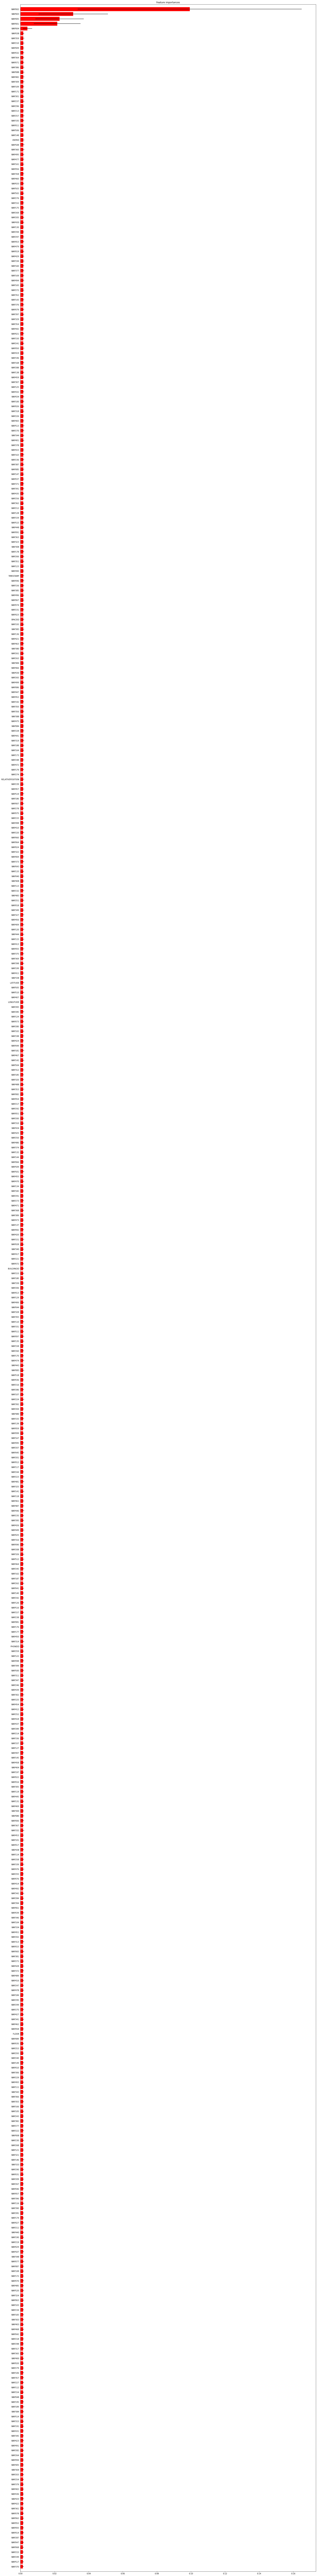

In [ ]:
# Feature Importances
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

feature_names = ['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006', 'WAP007', 'WAP008', 'WAP009', 'WAP010', 'WAP011', 'WAP012', 'WAP013', 'WAP014', 'WAP015', 'WAP016', 'WAP017', 'WAP018', 'WAP019', 'WAP020', 'WAP021', 'WAP022', 'WAP023', 'WAP024', 'WAP025', 'WAP026', 'WAP027', 'WAP028', 'WAP029', 'WAP030', 'WAP031', 'WAP032', 'WAP033', 'WAP034', 'WAP035', 'WAP036', 'WAP037', 'WAP038', 'WAP039', 'WAP040', 'WAP041', 'WAP042', 'WAP043', 'WAP044', 'WAP045', 'WAP046', 'WAP047', 'WAP048', 'WAP049', 'WAP050', 'WAP051', 'WAP052', 'WAP053', 'WAP054', 'WAP055', 'WAP056', 'WAP057', 'WAP058', 'WAP059', 'WAP060', 'WAP061', 'WAP062', 'WAP063', 'WAP064', 'WAP065', 'WAP066', 'WAP067', 'WAP068', 'WAP069', 'WAP070', 'WAP071', 'WAP072', 'WAP073', 'WAP074', 'WAP075', 'WAP076', 'WAP077', 'WAP078', 'WAP079', 'WAP080', 'WAP081', 'WAP082', 'WAP083', 'WAP084', 'WAP085', 'WAP086', 'WAP087', 'WAP088', 'WAP089', 'WAP090', 'WAP091', 'WAP092', 'WAP093', 'WAP094', 'WAP095', 'WAP096', 'WAP097', 'WAP098', 'WAP099', 'WAP100', 'WAP101', 'WAP102', 'WAP103', 'WAP104', 'WAP105', 'WAP106', 'WAP107', 'WAP108', 'WAP109', 'WAP110', 'WAP111', 'WAP112', 'WAP113', 'WAP114', 'WAP115', 'WAP116', 'WAP117', 'WAP118', 'WAP119', 'WAP120', 'WAP121', 'WAP122', 'WAP123', 'WAP124', 'WAP125', 'WAP126', 'WAP127', 'WAP128', 'WAP129', 'WAP130', 'WAP131', 'WAP132', 'WAP133', 'WAP134', 'WAP135', 'WAP136', 'WAP137', 'WAP138', 'WAP139', 'WAP140', 'WAP141', 'WAP142', 'WAP143', 'WAP144', 'WAP145', 'WAP146', 'WAP147', 'WAP148', 'WAP149', 'WAP150', 'WAP151', 'WAP152', 'WAP153', 'WAP154', 'WAP155', 'WAP156', 'WAP157', 'WAP158', 'WAP159', 'WAP160', 'WAP161', 'WAP162', 'WAP163', 'WAP164', 'WAP165', 'WAP166', 'WAP167', 'WAP168', 'WAP169', 'WAP170', 'WAP171', 'WAP172', 'WAP173', 'WAP174', 'WAP175', 'WAP176', 'WAP177', 'WAP178', 'WAP179', 'WAP180', 'WAP181', 'WAP182', 'WAP183', 'WAP184', 'WAP185', 'WAP186', 'WAP187', 'WAP188', 'WAP189', 'WAP190', 'WAP191', 'WAP192', 'WAP193', 'WAP194', 'WAP195', 'WAP196', 'WAP197', 'WAP198', 'WAP199', 'WAP200', 'WAP201', 'WAP202', 'WAP203', 'WAP204', 'WAP205', 'WAP206', 'WAP207', 'WAP208', 'WAP209', 'WAP210', 'WAP211', 'WAP212', 'WAP213', 'WAP214', 'WAP215', 'WAP216', 'WAP217', 'WAP218', 'WAP219', 'WAP220', 'WAP221', 'WAP222', 'WAP223', 'WAP224', 'WAP225', 'WAP226', 'WAP227', 'WAP228', 'WAP229', 'WAP230', 'WAP231', 'WAP232', 'WAP233', 'WAP234', 'WAP235', 'WAP236', 'WAP237', 'WAP238', 'WAP239', 'WAP240', 'WAP241', 'WAP242', 'WAP243', 'WAP244', 'WAP245', 'WAP246', 'WAP247', 'WAP248', 'WAP249', 'WAP250', 'WAP251', 'WAP252', 'WAP253', 'WAP254', 'WAP255', 'WAP256', 'WAP257', 'WAP258', 'WAP259', 'WAP260', 'WAP261', 'WAP262', 'WAP263', 'WAP264', 'WAP265', 'WAP266', 'WAP267', 'WAP268', 'WAP269', 'WAP270', 'WAP271', 'WAP272', 'WAP273', 'WAP274', 'WAP275', 'WAP276', 'WAP277', 'WAP278', 'WAP279', 'WAP280', 'WAP281', 'WAP282', 'WAP283', 'WAP284', 'WAP285', 'WAP286', 'WAP287', 'WAP288', 'WAP289', 'WAP290', 'WAP291', 'WAP292', 'WAP293', 'WAP294', 'WAP295', 'WAP296', 'WAP297', 'WAP298', 'WAP299', 'WAP300', 'WAP301', 'WAP302', 'WAP303', 'WAP304', 'WAP305', 'WAP306', 'WAP307', 'WAP308', 'WAP309', 'WAP310', 'WAP311', 'WAP312', 'WAP313', 'WAP314', 'WAP315', 'WAP316', 'WAP317', 'WAP318', 'WAP319', 'WAP320', 'WAP321', 'WAP322', 'WAP323', 'WAP324', 'WAP325', 'WAP326', 'WAP327', 'WAP328', 'WAP329', 'WAP330', 'WAP331', 'WAP332', 'WAP333', 'WAP334', 'WAP335', 'WAP336', 'WAP337', 'WAP338', 'WAP339', 'WAP340', 'WAP341', 'WAP342', 'WAP343', 'WAP344', 'WAP345', 'WAP346', 'WAP347', 'WAP348', 'WAP349', 'WAP350', 'WAP351', 'WAP352', 'WAP353', 'WAP354', 'WAP355', 'WAP356', 'WAP357', 'WAP358', 'WAP359', 'WAP360', 'WAP361', 'WAP362', 'WAP363', 'WAP364', 'WAP365', 'WAP366', 'WAP367', 'WAP368', 'WAP369', 'WAP370', 'WAP371', 'WAP372', 'WAP373', 'WAP374', 'WAP375', 'WAP376', 'WAP377', 'WAP378', 'WAP379', 'WAP380', 'WAP381', 'WAP382', 'WAP383', 'WAP384', 'WAP385', 'WAP386', 'WAP387', 'WAP388', 'WAP389', 'WAP390', 'WAP391', 'WAP392', 'WAP393', 'WAP394', 'WAP395', 'WAP396', 'WAP397', 'WAP398', 'WAP399', 'WAP400', 'WAP401', 'WAP402', 'WAP403', 'WAP404', 'WAP405', 'WAP406', 'WAP407', 'WAP408', 'WAP409', 'WAP410', 'WAP411', 'WAP412', 'WAP413', 'WAP414', 'WAP415', 'WAP416', 'WAP417', 'WAP418', 'WAP419', 'WAP420', 'WAP421', 'WAP422', 'WAP423', 'WAP424', 'WAP425', 'WAP426', 'WAP427', 'WAP428', 'WAP429', 'WAP430', 'WAP431', 'WAP432', 'WAP433', 'WAP434', 'WAP435', 'WAP436', 'WAP437', 'WAP438', 'WAP439', 'WAP440', 'WAP441', 'WAP442', 'WAP443', 'WAP444', 'WAP445', 'WAP446', 'WAP447', 'WAP448', 'WAP449', 'WAP450', 'WAP451', 'WAP452', 'WAP453', 'WAP454', 'WAP455', 'WAP456', 'WAP457', 'WAP458', 'WAP459', 'WAP460', 'WAP461', 'WAP462', 'WAP463', 'WAP464', 'WAP465', 'WAP466', 'WAP467', 'WAP468', 'WAP469', 'WAP470', 'WAP471', 'WAP472', 'WAP473', 'WAP474', 'WAP475', 'WAP476', 'WAP477', 'WAP478', 'WAP479', 'WAP480', 'WAP481', 'WAP482', 'WAP483', 'WAP484', 'WAP485', 'WAP486', 'WAP487', 'WAP488', 'WAP489', 'WAP490', 'WAP491', 'WAP492', 'WAP493', 'WAP494', 'WAP495', 'WAP496', 'WAP497', 'WAP498', 'WAP499', 'WAP500', 'WAP501', 'WAP502', 'WAP503', 'WAP504', 'WAP505', 'WAP506', 'WAP507', 'WAP508', 'WAP509', 'WAP510', 'WAP511', 'WAP512', 'WAP513', 'WAP514', 'WAP515', 'WAP516', 'WAP517', 'WAP518', 'WAP519', 'WAP520', 'LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID', 'SPACEID', 'RELATIVEPOSITION', 'USERID', 'PHONEID', 'TIMESTAMP']

# Build a classification task using 3 informative features
Xe, ye = make_classification(n_samples=19937,
                           n_features=529,
                           n_informative=5,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
plt.rcParams["figure.figsize"] = (28,250)
forest.fit(Xe, ye)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(Xe.shape[1]), importances[indices],
       color="r", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
#plt.yticks(range(Xa.shape[1]), indices)
plt.yticks(range(Xe.shape[1]), [feature_names[i] for i in indices])
plt.ylim([-1, Xe.shape[1]])
plt.show()

In [ ]:
train_data.isnull().sum().sum()

0

In [ ]:
# Output arrays for all predictions

# y for Lat & Long

y_lat = out_data.copy()
y_lat = y_lat.drop(['FLOOR', 'BUILDINGID', 'SPACEID', 'RELATIVEPOSITION'], axis = 1)
y_lat = lil_matrix(y_lat).toarray()


# y for Space

y_se = out_data.copy()
y_se = y_se.drop(['LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID', 'RELATIVEPOSITION'], axis = 1)
y_se = lil_matrix(y_se).toarray()


# y for Relative position 

y_rp = out_data.copy()
y_rp = y_rp.drop(['LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID', 'SPACEID'], axis = 1)
y_rp = lil_matrix(y_rp).toarray()



In [ ]:
# in_data normalization

scaler = StandardScaler()
scaler.fit(in_data)    
X = scaler.transform(in_data)
X.shape

(19937, 520)

In [ ]:
y_lat.shape, y_se.shape, y_rp.shape

((19937, 2), (19937, 1), (19937, 1))

In [ ]:
# Alternative when low accuracy

def preprocess_data(df):
    
    # split the data set into features and targets(Floor and BuildingID)
    X1 = train_data.drop(['LONGITUDE', 'LATITUDE', 'BUILDINGID','FLOOR'], axis=1)
    y1 = train_data[[ 'BUILDINGID']]
    
    X2 = train_data.drop(['LONGITUDE', 'LATITUDE','FLOOR'], axis=1)
    y2 = train_data[['FLOOR']]
    
    
    X3 = train_data.drop(['LONGITUDE', 'LATITUDE','FLOOR'], axis=1)
    y3 = train_data[[ 'LONGITUDE', 'LATITUDE']]
    
    #create Dummies for the targets to feed into the model
    y1 = pd.get_dummies(data=y1, columns=[ 'BUILDINGID'])
    y2 = pd.get_dummies(data=y2, columns=[ 'FLOOR']) 
    X3 = pd.get_dummies(data=X3, columns=['BUILDINGID']) 
    
    return X1, y1, X2, y2, X3, y3

In [ ]:
X1, y1, X2, y2, X3, y3 = preprocess_data(train_data)

In [ ]:
def preprocess_datasprp(df):
    
    # split the data set into features and targets(Floor and BuildingID)
    X4 = train_data.drop(['LONGITUDE', 'LATITUDE', 'SPACEID','RELATIVEPOSITION'], axis=1)
    y4 = train_data[[ 'SPACEID']]
    
    X5 = train_data.drop(['LONGITUDE', 'LATITUDE','RELATIVEPOSITION'], axis=1)
    y5 = train_data[['RELATIVEPOSITION']]
    
    
    
    #create Dummies for the targets to feed into the model
    y4 = pd.get_dummies(data=y4, columns=[ 'SPACEID'])
    y5 = pd.get_dummies(data=y5, columns=[ 'RELATIVEPOSITION']) 
    
    return X4,y4,X5,y5

In [ ]:
X4,y4,X5,y5=preprocess_datasprp(train_data)

In [ ]:
#Scale Data with Standard Scaler

scaler1 = StandardScaler()
scaler1.fit(X1)    
X1 = scaler1.transform(X1)

scaler2 = StandardScaler()
scaler2.fit(X2)
X2 = scaler2.transform(X2)

scaler3 = StandardScaler()
scaler3.fit(X3)
X3 = scaler3.transform(X3)

scaler4 = StandardScaler()
scaler4.fit(X4)
X4 = scaler4.transform(X4)

scaler5 = StandardScaler()
scaler5.fit(X5)
X5 = scaler5.transform(X5)

In [ ]:
y1 = lil_matrix(y1).toarray()
y2 = lil_matrix(y2).toarray()
y3 = lil_matrix(y3).toarray()
y4 = lil_matrix(y4).toarray()
y5 = lil_matrix(y5).toarray()

In [ ]:
X3.shape, y3.shape

((19937, 525), (19937, 2))

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=33)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X4, y4, test_size=0.2, random_state=1)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X5, y5, test_size=0.2, random_state=42)
X_train4, X_test4, y_train4, y_test4 = train_test_split(X3, y3, test_size=0.2, random_state=42)

### **Predicting Latitude and Longitude (LAT)**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(in_data, y_lat, test_size=0.25, random_state=45) 

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((14952, 520), (14952, 2), (4985, 520), (4985, 2))

#### Neural Network

In [ ]:
start_time = time.time()

# Define the model
model_3 = Sequential()
model_3.add(Dense(300, input_dim=520, activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.2))
model_3.add(Dense(300, activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.2))
model_3.add(Dense(300, activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dense(2, activation='linear'))
model_3.compile(loss='mean_absolute_error', optimizer='adam',metrics=['accuracy'])


model_3.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               156300    
_________________________________________________________________
batch_normalization (BatchNo (None, 300)               1200      
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               9

In [ ]:
monitor2 = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
hist_latlong=model_3.fit(
    x_train,
    y_train,
    batch_size=1024,
    validation_split = 0.4,
    epochs=150,
    shuffle=True,
    callbacks=[monitor2],
    verbose=2,
    validation_data=(x_test,y_test)
)

Epoch 1/150
9/9 - 1s - loss: 144.8047 - accuracy: 0.5293 - val_loss: 146.2377 - val_accuracy: 0.6124
Epoch 2/150
9/9 - 0s - loss: 144.6257 - accuracy: 0.5656 - val_loss: 145.3853 - val_accuracy: 0.6233
Epoch 3/150
9/9 - 1s - loss: 144.3846 - accuracy: 0.5569 - val_loss: 144.2734 - val_accuracy: 0.6170
Epoch 4/150
9/9 - 0s - loss: 144.0665 - accuracy: 0.5430 - val_loss: 143.7280 - val_accuracy: 0.6180
Epoch 5/150
9/9 - 1s - loss: 143.6587 - accuracy: 0.5387 - val_loss: 143.2832 - val_accuracy: 0.6017
Epoch 6/150
9/9 - 1s - loss: 143.1506 - accuracy: 0.5401 - val_loss: 142.7874 - val_accuracy: 0.5976
Epoch 7/150
9/9 - 0s - loss: 142.5339 - accuracy: 0.5343 - val_loss: 142.1968 - val_accuracy: 0.5874
Epoch 8/150
9/9 - 1s - loss: 141.8021 - accuracy: 0.5569 - val_loss: 141.4077 - val_accuracy: 0.6695
Epoch 9/150
9/9 - 0s - loss: 140.9501 - accuracy: 0.5783 - val_loss: 141.0341 - val_accuracy: 0.6768
Epoch 10/150
9/9 - 0s - loss: 139.9744 - accuracy: 0.5763 - val_loss: 140.7022 - val_accura

In [ ]:
pred = model_3.predict(x_test)

pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)


y_true= np.argmax(y_test,axis=1) 
sac1 = metrics.accuracy_score(y_true, pred)
print("Accuracy score: {}".format(sac1))

Accuracy score: 0.8383149448345035


In [ ]:
predictions3 = (model_3.predict(x_test))

# accuracy
print("RMSE of predicting LONGTITUDE = ", mean_absolute_error(y_test[:,0],predictions3[:,0]))
print("RMSE of predicting LATITUDE = ", mean_absolute_error(y_test[:,1],predictions3[:,1]))


print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

RMSE of predicting LONGTITUDE =  100.63656945945237
RMSE of predicting LATITUDE =  68.5277091210325
--- Run time: 5.0 mins ---


In [ ]:
print(hist_latlong.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


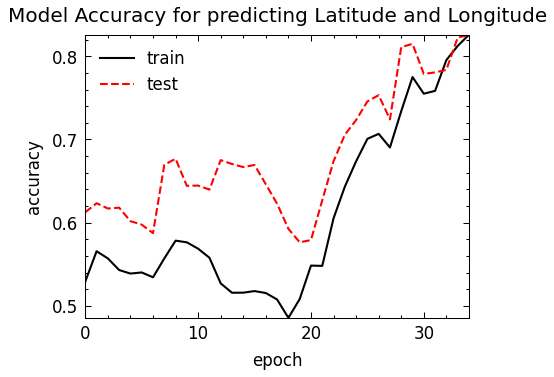

In [ ]:
import matplotlib.pyplot as plt

pparam = dict(xlabel='epoch', ylabel='accuracy', title='Model Accuracy for predicting Latitude and Longitude')

plt.style.reload_library()
plt.style.use(['science','no-latex'])
with plt.style.context(['science', 'ieee','no-latex']):
    fig, ax = plt.subplots(dpi=150)
    ax.plot(hist_latlong.history['accuracy'], label='train')
    ax.plot(hist_latlong.history['val_accuracy'], label='test')
    ax.legend(['train', 'test'], loc='upper left')
    ax.autoscale(tight=True)
    ax.set(**pparam)

In [ ]:
# Normalized
x_train, x_test, y_train, y_test = train_test_split(X, y_lat, test_size=0.3, random_state=45) 

In [ ]:
start_time = time.time()

# Define the model
model_3 = Sequential()
model_3.add(Dense(300, input_dim=520, activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.2))
model_3.add(Dense(150, activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.2))
model_3.add(Dense(150, activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dense(2, activation='linear'))
model_3.compile(loss='mean_absolute_error', optimizer='adam',metrics=['accuracy'])


model_3.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 300)               156300    
_________________________________________________________________
batch_normalization_3 (Batch (None, 300)               1200      
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 150)               45150     
_________________________________________________________________
batch_normalization_4 (Batch (None, 150)               600       
_________________________________________________________________
dropout_3 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 150)              

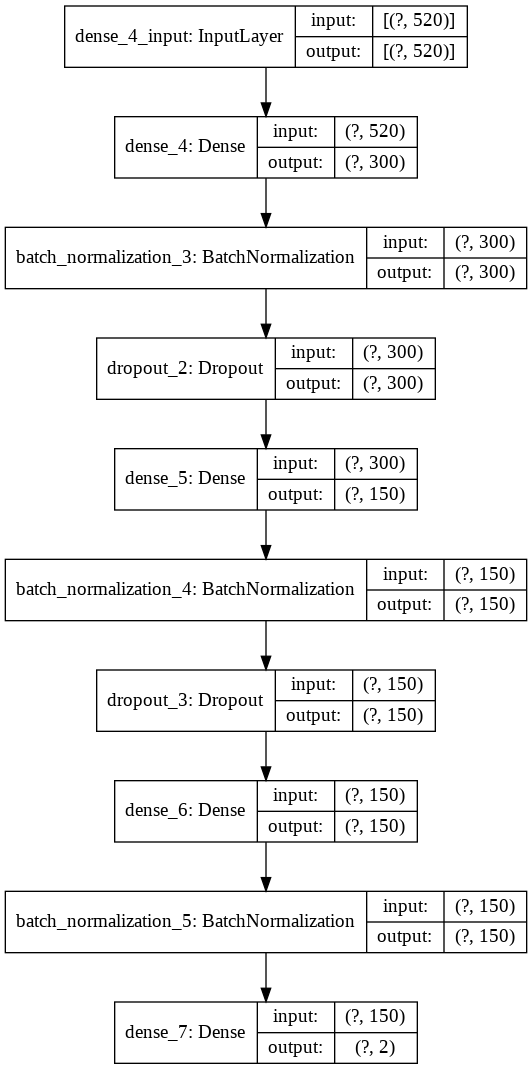

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
monitor2 = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
hist_latlong=model_3.fit(
    x_train,
    y_train,
    batch_size=1024,
    validation_split = 0.4,
    epochs=150,
    shuffle=True,
    callbacks=[monitor2],
    verbose=2,
    validation_data=(x_test,y_test)
)

Epoch 1/150
9/9 - 0s - loss: 144.5130 - accuracy: 0.4063 - val_loss: 145.7643 - val_accuracy: 0.4022
Epoch 2/150
9/9 - 0s - loss: 144.3925 - accuracy: 0.4493 - val_loss: 145.6147 - val_accuracy: 0.4292
Epoch 3/150
9/9 - 0s - loss: 144.2410 - accuracy: 0.4769 - val_loss: 145.2191 - val_accuracy: 0.5314
Epoch 4/150
9/9 - 0s - loss: 144.0518 - accuracy: 0.5150 - val_loss: 144.9004 - val_accuracy: 0.5708
Epoch 5/150
9/9 - 0s - loss: 143.8186 - accuracy: 0.5396 - val_loss: 144.6345 - val_accuracy: 0.5894
Epoch 6/150
9/9 - 0s - loss: 143.5363 - accuracy: 0.5421 - val_loss: 144.3530 - val_accuracy: 0.5960
Epoch 7/150
9/9 - 0s - loss: 143.2010 - accuracy: 0.5505 - val_loss: 144.0291 - val_accuracy: 0.5992
Epoch 8/150
9/9 - 0s - loss: 142.8094 - accuracy: 0.5471 - val_loss: 143.5805 - val_accuracy: 0.5991
Epoch 9/150
9/9 - 0s - loss: 142.3593 - accuracy: 0.5437 - val_loss: 142.8539 - val_accuracy: 0.5731
Epoch 10/150
9/9 - 0s - loss: 141.8492 - accuracy: 0.5308 - val_loss: 141.4613 - val_accura

In [ ]:
pred = model_3.predict(x_test)

pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)


y_true= np.argmax(y_test,axis=1) 
sac1 = metrics.accuracy_score(y_true, pred)
print("Accuracy score: {}".format(sac1))

Accuracy score: 0.9791039786024741


In [ ]:
predictions3 = (model_3.predict(x_test))

# accuracy
print("RMSE of predicting LONGTITUDE = ", mean_absolute_error(y_test[:,0],predictions3[:,0]))
print("RMSE of predicting LATITUDE = ", mean_absolute_error(y_test[:,1],predictions3[:,1]))


print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

RMSE of predicting LONGTITUDE =  6.257122090553019
RMSE of predicting LATITUDE =  4.844840732193388
--- Run time: 1.1 mins ---


In [ ]:
print(hist_latlong.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


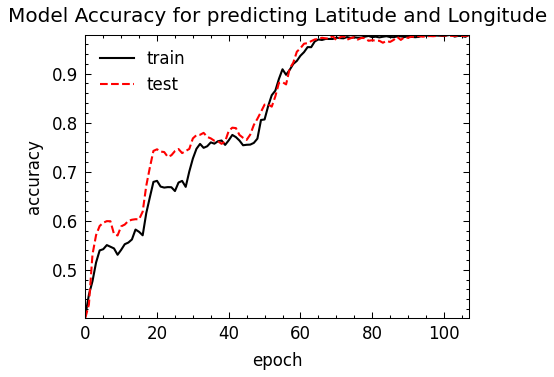

In [ ]:
pparam = dict(xlabel='epoch', ylabel='accuracy', title='Model Accuracy for predicting Latitude and Longitude')

plt.style.reload_library()
plt.style.use(['science','no-latex'])
with plt.style.context(['science', 'ieee','no-latex']):
    fig, ax = plt.subplots(dpi=150)
    ax.plot(hist_latlong.history['accuracy'], label='train')
    ax.plot(hist_latlong.history['val_accuracy'], label='test')
    ax.legend(['train', 'test'], loc='upper left')
    ax.autoscale(tight=True)
    ax.set(**pparam)

#### CNN


In [ ]:
X_cnn = train_data.copy()
X_cnn = X_cnn.drop([], axis = 1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_cnn, y3, test_size=0.2, random_state=45) 

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((15949, 526), (15949, 2), (3988, 526), (3988, 2))

In [ ]:
type(y_train)

numpy.ndarray

In [ ]:
x_train = x_train.values.reshape(x_train.shape[0],526,1,1)
x_test = x_test.values.reshape(x_test.shape[0],526,1,1)

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((15949, 526, 1, 1), (15949, 2), (3988, 526, 1, 1), (3988, 2))

In [ ]:
#SAMPLE1
model = Sequential()
# input_shape = (maximum_length_of_string,vector_size,1)
# print(input_shape)
# model.add(Embedding(128,input_length=max_tweet_length))
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same',data_format=None,
                 activation='relu',
                 batch_size=None,
                 input_shape=(526,1,1)))
model.add(MaxPooling2D(pool_size=(1, 1), strides=None))
model.add(Dropout(0.5)) 
model.add(Flatten())
model.add(Dense(y3.shape[1]))
model.compile(optimizer='adam', loss='mse', metrics = ['accuracy'])
model.summary()
# model.compile(loss='binary_crossentropy', optimizer=sgd, metrics = ['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
# checkpointer = ModelCheckpoint(filepath="dnn/cnnm1.hdf5", verbose=0, save_best_only=True) # save best model
hist_latlong = model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=1, epochs=20)
# model.load_weights('dnn/cnnm1.hdf5') # load weights from best model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 526, 1, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 526, 1, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 526, 1, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16832)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 33666     
Total params: 33,986
Trainable params: 33,986
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
499/499 [==============================] - 10s 20ms/step - loss: 1606.1305 - accuracy: 0.8883 - val_loss:

In [ ]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)
y_true= np.argmax(y_test,axis=1) 
sac1 = metrics.accuracy_score(y_true, pred)
print("Accuracy score for drop rate 0.6 is {}".format(sac1))

Accuracy score for drop rate 0.6 is 0.9839518555667001


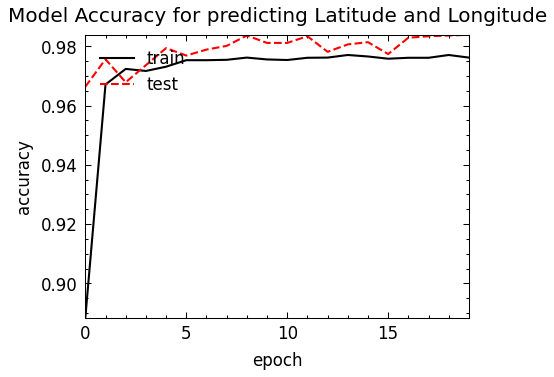

In [ ]:
pparam = dict(xlabel='epoch', ylabel='accuracy', title='Model Accuracy for predicting Latitude and Longitude')

plt.style.reload_library()
plt.style.use(['science','no-latex'])
with plt.style.context(['science', 'ieee','no-latex']):
    fig, ax = plt.subplots(dpi=150)
    ax.plot(hist_latlong.history['accuracy'], label='train')
    ax.plot(hist_latlong.history['val_accuracy'], label='test')
    ax.legend(['train', 'test'], loc='upper left')
    ax.autoscale(tight=True)
    ax.set(**pparam)

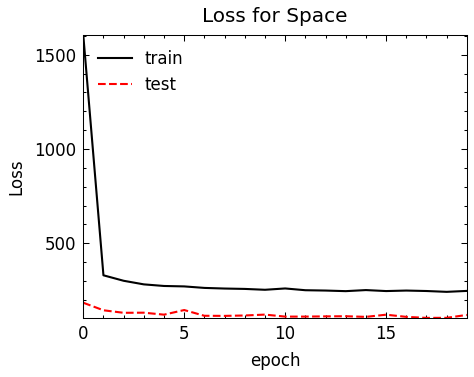

In [ ]:
pparam = dict(xlabel='epoch', ylabel='Loss', title='Loss for Space')

plt.style.reload_library()
plt.style.use(['science','no-latex'])
with plt.style.context(['science', 'ieee','no-latex']):
    fig, ax = plt.subplots(dpi=150)
    ax.plot(hist_latlong.history['loss'], label='train')
    ax.plot(hist_latlong.history['val_loss'], label='test')
    ax.legend(['train', 'test'], loc='upper left')
    ax.autoscale(tight=True)
    ax.set(**pparam)

In [ ]:
# from keras.optimizers import SGD 

dr = 0.85 # dropout rate (%)
model_lat = tf.keras.models.Sequential()
model_lat.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), input_shape=(526,1,1), activation="relu", name="conv1", padding='same'))
model_lat.add(MaxPooling2D(pool_size=(1,1)))
model_lat.add(Dropout(dr))
model_lat.add(Dense(300, name="dense1"))
model_lat.add(Dropout(dr))
model_lat.add(Dense(150, name="dense2"))
model_lat.add(Dropout(dr))
model_lat.add(Dense(150, name="dense3"))
model_lat.add(Flatten())
model_lat.add(Dense(2,activation='softmax', name="dense4"))
model_lat.compile(loss='mean_absolute_error', optimizer="Adam" , metrics=['accuracy'])
model_lat.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 526, 1, 64)        640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 526, 1, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 526, 1, 64)        0         
_________________________________________________________________
dense1 (Dense)               (None, 526, 1, 300)       19500     
_________________________________________________________________
dropout_7 (Dropout)          (None, 526, 1, 300)       0         
_________________________________________________________________
dense2 (Dense)               (None, 526, 1, 150)       45150     
_________________________________________________________________
dropout_8 (Dropout)          (None, 526, 1, 150)      

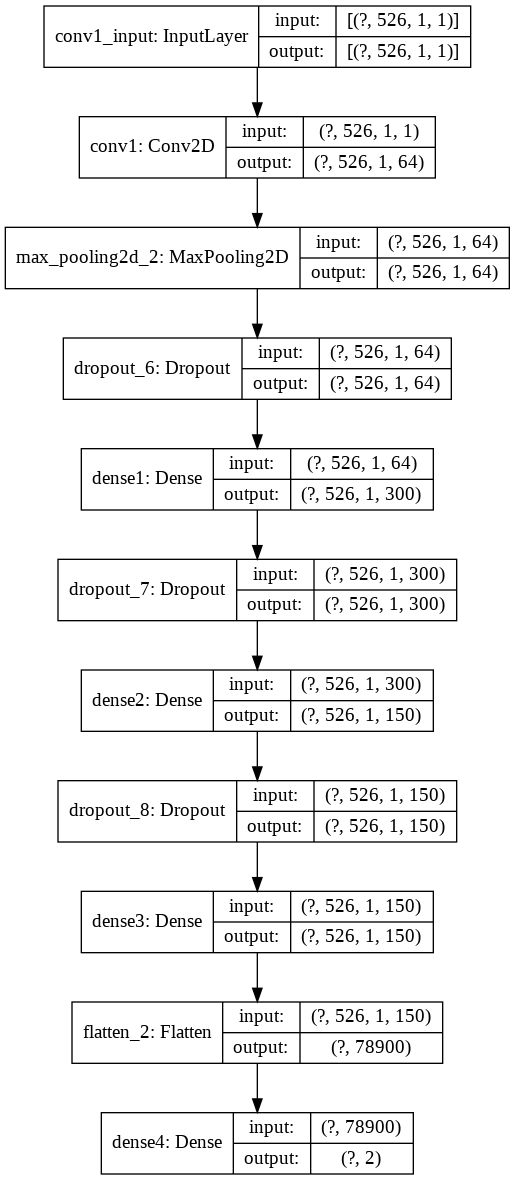

In [ ]:
tf.keras.utils.plot_model(
    model_lat,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [ ]:
# dr = 0.6
monitor3 = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
hist_cnn=model_lat.fit(x_train,
    y_train,
    batch_size=128,
    epochs=100,
    callbacks=[monitor3],
    verbose=1,
    validation_data=(x_test,y_test))

Epoch 1/100
125/125 [==============================] - 134s 1s/step - loss: 144.7179 - accuracy: 0.5146 - val_loss: 144.4927 - val_accuracy: 0.6058
Epoch 2/100
125/125 [==============================] - 133s 1s/step - loss: 144.7179 - accuracy: 0.5292 - val_loss: 144.4927 - val_accuracy: 0.6058
Epoch 3/100
125/125 [==============================] - 133s 1s/step - loss: 144.7179 - accuracy: 0.5390 - val_loss: 144.4927 - val_accuracy: 0.6058
Epoch 4/100
125/125 [==============================] - 134s 1s/step - loss: 144.7179 - accuracy: 0.5447 - val_loss: 144.4927 - val_accuracy: 0.6058
Epoch 5/100
125/125 [==============================] - 134s 1s/step - loss: 144.7178 - accuracy: 0.5513 - val_loss: 144.4927 - val_accuracy: 0.6058
Epoch 6/100
125/125 [==============================] - 133s 1s/step - loss: 144.7179 - accuracy: 0.5530 - val_loss: 144.4927 - val_accuracy: 0.6058
Epoch 7/100
125/125 [==============================] - 133s 1s/step - loss: 144.7179 - accuracy: 0.5513 - val_lo

In [ ]:
pred = model_lat.predict(x_test)
pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)
y_true= np.argmax(y_test,axis=1) 
sac1 = metrics.accuracy_score(y_true, pred)
print("Accuracy score for drop rate 0.6 is {}".format(sac1))

Accuracy score for drop rate 0.6 is 0.6058174523570712


In [ ]:
hist_cnn.history

{'accuracy': [0.5145776867866516,
  0.5291867852210999,
  0.5390306711196899,
  0.5447363257408142,
  0.5512571334838867,
  0.5530127286911011,
  0.5513198375701904,
  0.550065815448761,
  0.5859301686286926,
  0.6012288928031921,
  0.601918637752533],
 'loss': [144.71792602539062,
  144.71788024902344,
  144.7178955078125,
  144.7178955078125,
  144.7178497314453,
  144.71788024902344,
  144.71786499023438,
  144.7178497314453,
  144.7178497314453,
  144.71788024902344,
  144.7178955078125],
 'val_accuracy': [0.605817437171936,
  0.605817437171936,
  0.605817437171936,
  0.605817437171936,
  0.605817437171936,
  0.605817437171936,
  0.605817437171936,
  0.605817437171936,
  0.605817437171936,
  0.605817437171936,
  0.605817437171936],
 'val_loss': [144.4927215576172,
  144.4927215576172,
  144.4927215576172,
  144.4927215576172,
  144.4927215576172,
  144.4927215576172,
  144.4927215576172,
  144.4927215576172,
  144.4927215576172,
  144.4927215576172,
  144.4927215576172]}

In [ ]:
# dr = 0.25
monitor3 = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
hist_cnn=model_lat.fit(x_train,
    y_train,
    batch_size=1024,
    epochs=100,
    callbacks=[monitor3],
    verbose=2,
    validation_data=(x_test,y_test))

Epoch 1/100
16/16 - 126s - loss: 144.7178 - accuracy: 0.6020 - val_loss: 144.4927 - val_accuracy: 0.6058
Epoch 2/100
16/16 - 125s - loss: 144.7178 - accuracy: 0.6020 - val_loss: 144.4927 - val_accuracy: 0.6058
Epoch 3/100
16/16 - 125s - loss: 144.7179 - accuracy: 0.6032 - val_loss: 144.4927 - val_accuracy: 0.6058
Epoch 4/100
16/16 - 125s - loss: 144.7178 - accuracy: 0.6025 - val_loss: 144.4927 - val_accuracy: 0.6058
Epoch 5/100
16/16 - 127s - loss: 144.7179 - accuracy: 0.6012 - val_loss: 144.4927 - val_accuracy: 0.6058
Epoch 6/100
16/16 - 125s - loss: 144.7178 - accuracy: 0.6014 - val_loss: 144.4927 - val_accuracy: 0.6058
Epoch 7/100
16/16 - 125s - loss: 144.7178 - accuracy: 0.6011 - val_loss: 144.4927 - val_accuracy: 0.6058
Epoch 8/100
16/16 - 125s - loss: 144.7179 - accuracy: 0.6014 - val_loss: 144.4927 - val_accuracy: 0.6058
Epoch 9/100
16/16 - 125s - loss: 144.7178 - accuracy: 0.6011 - val_loss: 144.4927 - val_accuracy: 0.6058
Epoch 10/100
16/16 - 127s - loss: 144.7178 - accuracy: 

In [ ]:
pred = model_lat.predict(x_test)
pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)
y_true= np.argmax(y_test,axis=1) 
sac1 = metrics.accuracy_score(y_true, pred)
print("Accuracy score for drop rate 0.25: {}".format(sac1))

Accuracy score for drop rate 0.25: 0.6058174523570712


In [ ]:
# dr = 0.85
monitor3 = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
hist_cnn=model_lat.fit(x_train,
    y_train,
    batch_size=1024,
    epochs=100,
    callbacks=[monitor3],
    verbose=2,
    validation_data=(x_test,y_test))

Epoch 1/100
16/16 - 125s - loss: 144.7178 - accuracy: 0.6017 - val_loss: 144.4927 - val_accuracy: 0.6058
Epoch 2/100
16/16 - 128s - loss: 144.7179 - accuracy: 0.6019 - val_loss: 144.4927 - val_accuracy: 0.6058
Epoch 3/100
16/16 - 125s - loss: 144.7178 - accuracy: 0.6017 - val_loss: 144.4927 - val_accuracy: 0.6058
Epoch 4/100
16/16 - 125s - loss: 144.7178 - accuracy: 0.6023 - val_loss: 144.4927 - val_accuracy: 0.6058
Epoch 5/100
16/16 - 126s - loss: 144.7179 - accuracy: 0.6004 - val_loss: 144.4927 - val_accuracy: 0.6058
Epoch 6/100
16/16 - 129s - loss: 144.7178 - accuracy: 0.6017 - val_loss: 144.4927 - val_accuracy: 0.6058
Epoch 7/100
16/16 - 131s - loss: 144.7179 - accuracy: 0.6011 - val_loss: 144.4927 - val_accuracy: 0.6058
Epoch 8/100
16/16 - 127s - loss: 144.7178 - accuracy: 0.6021 - val_loss: 144.4927 - val_accuracy: 0.6058
Epoch 9/100
16/16 - 126s - loss: 144.7179 - accuracy: 0.6020 - val_loss: 144.4927 - val_accuracy: 0.6058
Epoch 10/100
16/16 - 127s - loss: 144.7178 - accuracy: 

In [ ]:
pred = model_lat.predict(x_test)
pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)
y_true= np.argmax(y_test,axis=1) 
sac1 = metrics.accuracy_score(y_true, pred)
print("Accuracy score: {}".format(sac1))

Accuracy score: 0.6058174523570712


#### LSTM

In [ ]:
def to_sequences(seq_size, data1, data2):
    x = []
    
    y = []

    for i in range(len(data1)-seq_size):
        #print(i)
        window = data1[i:(i+seq_size)]
        after_window = data2[i+seq_size]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x), np.array(y)

In [ ]:
SEQUENCE_SIZE = 1

x_lat1,y_lat1 = to_sequences(SEQUENCE_SIZE,X3,y3)

In [ ]:
x_lat1.shape,y_lat1.shape

((19936, 1, 1, 525), (19936, 2))

In [ ]:
x_lat1=np.reshape(x_lat1,(19936,1,525))

In [ ]:
x_lat1.shape[2], y3.shape[1]

(525, 2)

In [ ]:
 X_trainls, X_testls, y_trainls, y_testls = train_test_split(x_lat1, y_lat1, test_size=0.3, random_state=42)

In [ ]:
modellong = Sequential()

modellong.add(LSTM(64,dropout=0.1, recurrent_dropout=0.1,  input_shape=(1,525),activation ='relu'))
modellong.add(Dense(200))
modellong.add(Dense(100))
modellong.add(Dense(y3.shape[1]))

modellong.compile(loss='categorical_crossentropy', optimizer='RMSprop')
modellong.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                151040    
_________________________________________________________________
dense_10 (Dense)             (None, 200)               13000     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 202       
Total params: 184,342
Trainable params: 184,342
Non-trainable params: 0
_________________________________________________________________


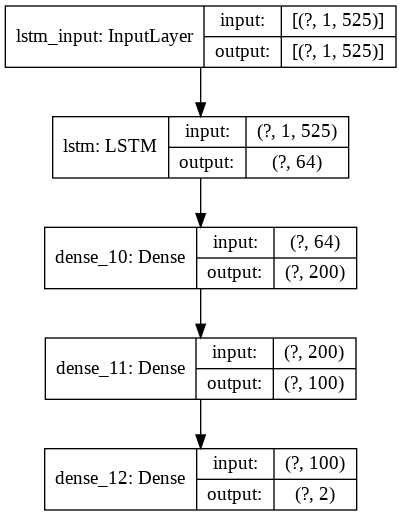

In [ ]:
tf.keras.utils.plot_model(
    modellong,
    to_file="model_lstm.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')


hist_long = modellong.fit(X_trainls,y_trainls,validation_data=(X_testls,y_testls), callbacks=[monitor],verbose=2,epochs = 100)

Epoch 1/100
437/437 - 3s - loss: 207.1965 - val_loss: 191.5926
Epoch 2/100
437/437 - 3s - loss: 193.2001 - val_loss: 192.1681
Epoch 3/100
437/437 - 3s - loss: 193.0715 - val_loss: 192.3143
Epoch 4/100
437/437 - 3s - loss: 193.0125 - val_loss: 191.1779
Epoch 5/100
437/437 - 3s - loss: 192.9541 - val_loss: 190.8544
Epoch 6/100
437/437 - 3s - loss: 192.9424 - val_loss: 190.9102
Epoch 7/100
437/437 - 3s - loss: 192.9170 - val_loss: 191.2393
Epoch 8/100
437/437 - 3s - loss: 192.8769 - val_loss: 190.9172
Epoch 9/100
437/437 - 2s - loss: 192.8507 - val_loss: 190.9947
Epoch 10/100
437/437 - 3s - loss: 192.8767 - val_loss: 191.0158
Epoch 00010: early stopping


In [ ]:
pred = modellong.predict(X_testls)

pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)


y_true= np.argmax(y_testls,axis=1) 
sac1 = metrics.accuracy_score(y_true, pred)
print("Accuracy score: {}".format(sac1))

Accuracy score: 0.06269854539374686


In [ ]:
predictions4_lstm = (modellong.predict(X_testls))

# accuracy
print("RMSE of predicting LONGTITUDE using LSTM = ", mean_absolute_error(y_testls[:,0],predictions4_lstm[:,0]))
print("RMSE of predicting LATITUDE using LSTM = ", mean_absolute_error(y_testls[:,1],predictions4_lstm[:,1]))

RMSE of predicting LONGTITUDE using LSTM =  272.38140184467943
RMSE of predicting LATITUDE using LSTM =  205.8201258786051


#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf_plot = rf.fit(X, y_lat);

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(X)
# Calculate the absolute errors
errors = abs(predictions - y_lat)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 1.22 degrees.


In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_lat)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 97.63 %.


### **Predicting Space**

#### Neural Network


In [ ]:
# Normalized
x_train, x_test, y_train, y_test = train_test_split(X4, y4, test_size=0.3, random_state=45) 

In [ ]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(13955, 522) (5982, 522) (13955, 123) (5982, 123)


In [ ]:
print(X4.shape,y4.shape)

(19937, 522) (19937, 123)


In [ ]:
print(y_test)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# Define the model
model_2 = Sequential()
model_2.add(Dense(150, input_dim=522, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.2))
model_2.add(Dense(150, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.2))
model_2.add(Dense(50, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dense(123, activation='softmax'))
model_2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

model_2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 150)               78450     
_________________________________________________________________
batch_normalization_6 (Batch (None, 150)               600       
_________________________________________________________________
dropout_9 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 150)               22650     
_________________________________________________________________
batch_normalization_7 (Batch (None, 150)               600       
_________________________________________________________________
dropout_10 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)               

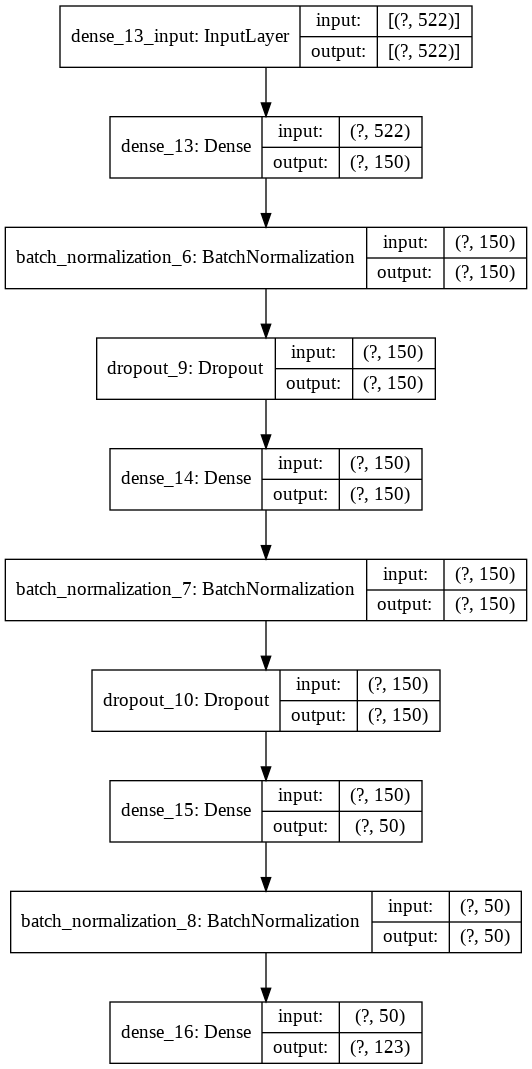

In [ ]:
plot_model(model_2, to_file='model_space.png', show_shapes=True, show_layer_names=True)

In [ ]:
monitor2 = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
hist_latlong=model_2.fit(
    x_train,
    y_train,
    batch_size=1024,
    validation_split = 0.4,
    epochs=150,
    shuffle=True,
    callbacks=[monitor2],
    verbose=2,
    validation_data=(x_test,y_test)
)

Epoch 1/150
9/9 - 0s - loss: 0.0481 - accuracy: 0.0162 - val_loss: 0.0465 - val_accuracy: 0.0197
Epoch 2/150
9/9 - 0s - loss: 0.0446 - accuracy: 0.0641 - val_loss: 0.0453 - val_accuracy: 0.0740
Epoch 3/150
9/9 - 0s - loss: 0.0423 - accuracy: 0.1147 - val_loss: 0.0441 - val_accuracy: 0.1105
Epoch 4/150
9/9 - 0s - loss: 0.0403 - accuracy: 0.1407 - val_loss: 0.0430 - val_accuracy: 0.1324
Epoch 5/150
9/9 - 0s - loss: 0.0386 - accuracy: 0.1751 - val_loss: 0.0417 - val_accuracy: 0.1671
Epoch 6/150
9/9 - 0s - loss: 0.0369 - accuracy: 0.2077 - val_loss: 0.0404 - val_accuracy: 0.1865
Epoch 7/150
9/9 - 0s - loss: 0.0355 - accuracy: 0.2245 - val_loss: 0.0391 - val_accuracy: 0.2126
Epoch 8/150
9/9 - 0s - loss: 0.0339 - accuracy: 0.2562 - val_loss: 0.0377 - val_accuracy: 0.2356
Epoch 9/150
9/9 - 0s - loss: 0.0326 - accuracy: 0.2716 - val_loss: 0.0364 - val_accuracy: 0.2576
Epoch 10/150
9/9 - 0s - loss: 0.0314 - accuracy: 0.2962 - val_loss: 0.0351 - val_accuracy: 0.2757
Epoch 11/150
9/9 - 0s - loss:

In [ ]:
pred = model_2.predict(x_test)

pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)


y_true= np.argmax(y_test,axis=1) 
sac1 = metrics.accuracy_score(y_true, pred)
print("Accuracy score: {}".format(sac1))

Accuracy score: 0.587930458040789


In [ ]:
print(hist_latlong.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


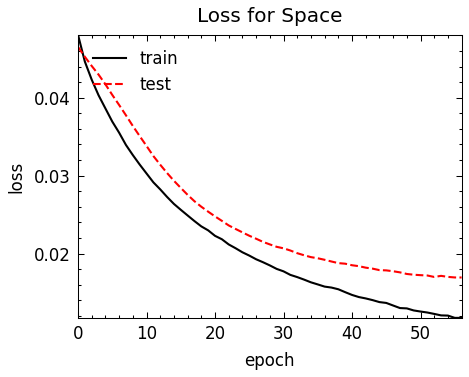

In [ ]:
import matplotlib.pyplot as plt

pparam = dict(xlabel='epoch', ylabel='loss', title='Loss for Space')

plt.style.reload_library()
plt.style.use(['science','no-latex'])
with plt.style.context(['science', 'ieee','no-latex']):
    fig, ax = plt.subplots(dpi=150)
    ax.plot(hist_latlong.history['loss'], label='train')
    ax.plot(hist_latlong.history['val_loss'], label='test')
    ax.legend(['train', 'test'], loc='upper left')
    ax.autoscale(tight=True)
    ax.set(**pparam)


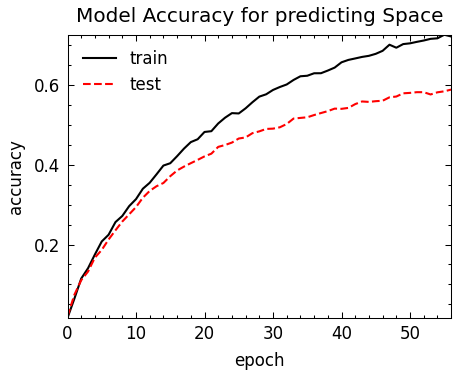

In [ ]:
pparam = dict(xlabel='epoch', ylabel='accuracy', title='Model Accuracy for predicting Space')

plt.style.reload_library()
plt.style.use(['science','no-latex'])
with plt.style.context(['science', 'ieee','no-latex']):
    fig, ax = plt.subplots(dpi=150)
    ax.plot(hist_latlong.history['accuracy'], label='train')
    ax.plot(hist_latlong.history['val_accuracy'], label='test')
    ax.legend(['train', 'test'], loc='upper left')
    ax.autoscale(tight=True)
    ax.set(**pparam)


In [ ]:
# Define the model
model_3 = Sequential()
model_3.add(Dense(256, input_dim=522, activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.5))
model_3.add(Dense(200))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.5))
model_3.add(Dense(120))
model_3.add(BatchNormalization())
model_3.add(Dense(123, activation='softmax'))
model_3.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

model_3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 256)               133888    
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 200)               51400     
_________________________________________________________________
batch_normalization_10 (Batc (None, 200)               800       
_________________________________________________________________
dropout_12 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 120)              

In [ ]:
monitor3 = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
hist_latlong=model_3.fit(
    x_train,
    y_train,
    batch_size=1024,
    validation_split = 0.4,
    epochs=150,
    shuffle=True,
    callbacks=[monitor3],
    verbose=1,
    validation_data=(x_test,y_test)
)

Epoch 1/150
9/9 [==============================] - 1s 59ms/step - loss: 4.9944 - accuracy: 0.0238 - val_loss: 4.3941 - val_accuracy: 0.0804
Epoch 2/150
9/9 [==============================] - 0s 41ms/step - loss: 4.4077 - accuracy: 0.0783 - val_loss: 3.9078 - val_accuracy: 0.1241
Epoch 3/150
9/9 [==============================] - 0s 39ms/step - loss: 3.9719 - accuracy: 0.1166 - val_loss: 3.5347 - val_accuracy: 0.1446
Epoch 4/150
9/9 [==============================] - 0s 40ms/step - loss: 3.6493 - accuracy: 0.1387 - val_loss: 3.2347 - val_accuracy: 0.1723
Epoch 5/150
9/9 [==============================] - 0s 40ms/step - loss: 3.3962 - accuracy: 0.1647 - val_loss: 3.0287 - val_accuracy: 0.1967
Epoch 6/150
9/9 [==============================] - 0s 41ms/step - loss: 3.2130 - accuracy: 0.1823 - val_loss: 2.8859 - val_accuracy: 0.2119
Epoch 7/150
9/9 [==============================] - 0s 41ms/step - loss: 3.0589 - accuracy: 0.2049 - val_loss: 2.7642 - val_accuracy: 0.2261
Epoch 8/150
9/9 [===

In [ ]:
pred3 = model_3.predict(x_test)

pred3 = np.argmax(pred3,axis=1) # raw probabilities to choose class (highest probability)


y_true3= np.argmax(y_test,axis=1) 
sac3 = metrics.accuracy_score(y_true3, pred3)
print("Accuracy score: {}".format(sac3))

Accuracy score: 0.5341023069207623


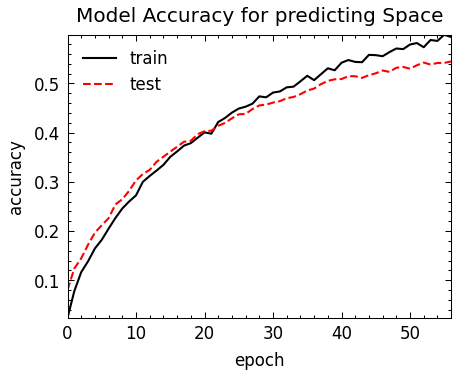

In [ ]:
pparam = dict(xlabel='epoch', ylabel='accuracy', title='Model Accuracy for predicting Space')

plt.style.reload_library()
plt.style.use(['science','no-latex'])
with plt.style.context(['science', 'ieee','no-latex']):
    fig, ax = plt.subplots(dpi=150)
    ax.plot(hist_latlong.history['accuracy'], label='train')
    ax.plot(hist_latlong.history['val_accuracy'], label='test')
    ax.legend(['train', 'test'], loc='upper left')
    ax.autoscale(tight=True)
    ax.set(**pparam)

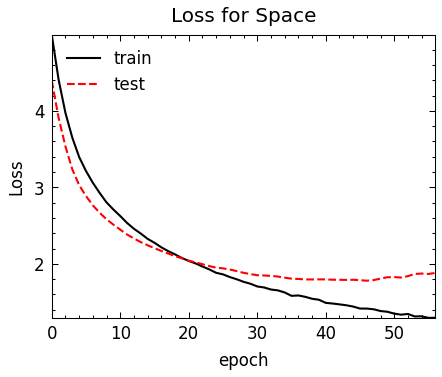

In [ ]:
pparam = dict(xlabel='epoch', ylabel='Loss', title='Loss for Space')

plt.style.reload_library()
plt.style.use(['science','no-latex'])
with plt.style.context(['science', 'ieee','no-latex']):
    fig, ax = plt.subplots(dpi=150)
    ax.plot(hist_latlong.history['loss'], label='train')
    ax.plot(hist_latlong.history['val_loss'], label='test')
    ax.legend(['train', 'test'], loc='upper left')
    ax.autoscale(tight=True)
    ax.set(**pparam)

#### CNN


In [ ]:
X4.shape, y4.shape

((19937, 522), (19937, 123))

In [ ]:
in_shp1 = np.reshape(X4, (19937,1,522,1))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(in_shp1, y4, test_size=0.2, random_state=45) 

In [ ]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(15949, 1, 522, 1) (3988, 1, 522, 1) (15949, 123) (3988, 123)


In [ ]:
dr = 0.5 # dropout rate (%)
model = Sequential() 
model.add(Conv2D(64, kernel_size=(1,5), strides=(1,1), input_shape=(1,522,1), padding='same', activation="relu", name="conv1",))
model.add(MaxPooling2D(pool_size=(1,1)))
model.add(Flatten())
model.add(Dropout(dr))
model.add(Dense(150,  name="dense1"))
model.add(Dense(150, name="dense2"))
model.add(Dense(123,activation='softmax', name="dense3"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.build()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 1, 522, 64)        384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 522, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 33408)             0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 33408)             0         
_________________________________________________________________
dense1 (Dense)               (None, 150)               5011350   
_________________________________________________________________
dense2 (Dense)               (None, 150)               22650     
_________________________________________________________________
dense3 (Dense)               (None, 123)              

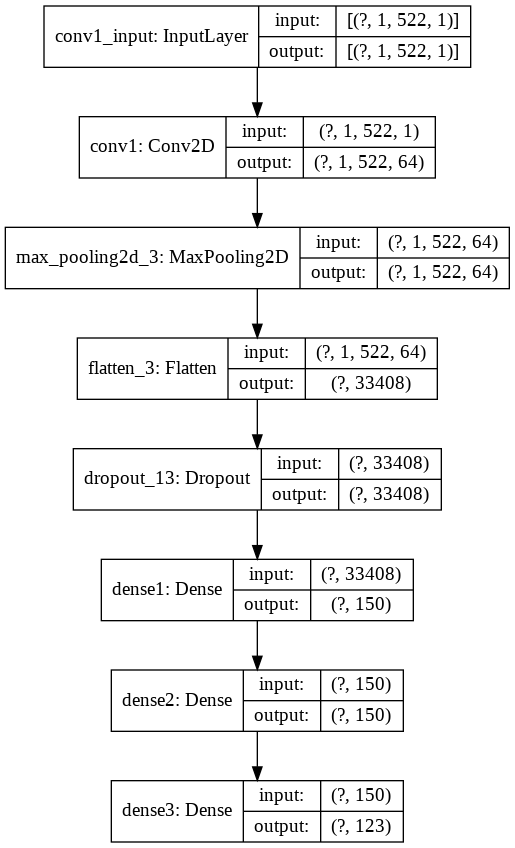

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="modelcnn.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [ ]:
#when dr = 0.5
monitor3 = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
hist_cnn=model.fit(x_train,
    y_train,
    batch_size=1024,
    epochs=100,
    callbacks=[monitor3],
    verbose=1,
    validation_data=(x_test,y_test))

Epoch 1/100
16/16 [==============================] - 19s 1s/step - loss: 3.4219 - accuracy: 0.1790 - val_loss: 2.6071 - val_accuracy: 0.2703
Epoch 2/100
16/16 [==============================] - 18s 1s/step - loss: 2.2320 - accuracy: 0.3559 - val_loss: 2.1629 - val_accuracy: 0.3641
Epoch 3/100
16/16 [==============================] - 18s 1s/step - loss: 1.8852 - accuracy: 0.4340 - val_loss: 1.9534 - val_accuracy: 0.4107
Epoch 4/100
16/16 [==============================] - 18s 1s/step - loss: 1.6852 - accuracy: 0.4871 - val_loss: 1.8270 - val_accuracy: 0.4541
Epoch 5/100
16/16 [==============================] - 18s 1s/step - loss: 1.5411 - accuracy: 0.5184 - val_loss: 1.7635 - val_accuracy: 0.4784
Epoch 6/100
16/16 [==============================] - 19s 1s/step - loss: 1.4395 - accuracy: 0.5509 - val_loss: 1.6894 - val_accuracy: 0.4945
Epoch 7/100
16/16 [==============================] - 18s 1s/step - loss: 1.3721 - accuracy: 0.5740 - val_loss: 1.6617 - val_accuracy: 0.5095
Epoch 8/100
1

In [ ]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)
y_true= np.argmax(y_test,axis=1) 
sac1 = metrics.accuracy_score(y_true, pred)
print("Accuracy score: {}".format(sac1))

Accuracy score: 0.6336509528585758


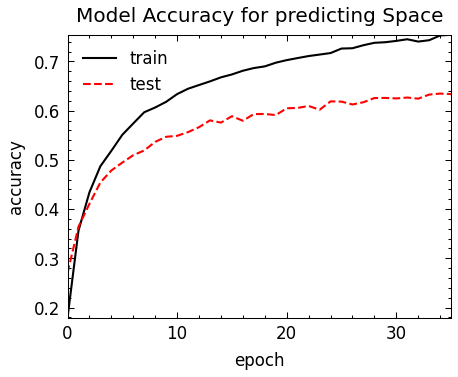

In [ ]:
pparam = dict(xlabel='epoch', ylabel='accuracy', title='Model Accuracy for predicting Space')

plt.style.reload_library()
plt.style.use(['science','no-latex'])
with plt.style.context(['science', 'ieee','no-latex']):
    fig, ax = plt.subplots(dpi=150)
    ax.plot(hist_cnn.history['accuracy'], label='train')
    ax.plot(hist_cnn.history['val_accuracy'], label='test')
    ax.legend(['train', 'test'], loc='upper left')
    ax.autoscale(tight=True)
    ax.set(**pparam)

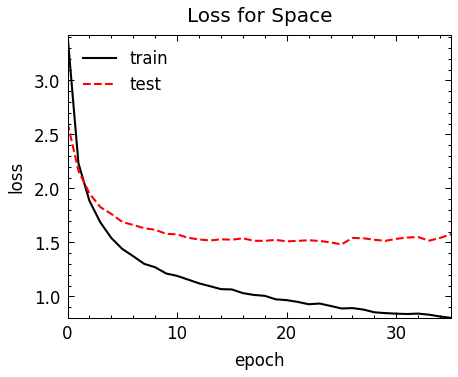

In [ ]:
pparam = dict(xlabel='epoch', ylabel='loss', title='Loss for Space')

plt.style.reload_library()
plt.style.use(['science','no-latex'])
with plt.style.context(['science', 'ieee','no-latex']):
    fig, ax = plt.subplots(dpi=150)
    ax.plot(hist_cnn.history['loss'], label='train')
    ax.plot(hist_cnn.history['val_loss'], label='test')
    ax.legend(['train', 'test'], loc='upper left')
    ax.autoscale(tight=True)
    ax.set(**pparam)

#### LSTM


In [ ]:
SEQUENCE_SIZE = 1
x_LSTM,y_LSTM = to_sequences(SEQUENCE_SIZE,X4,y4) 

In [ ]:
x_LSTM.shape,y_LSTM.shape

((19936, 1, 1, 522), (19936, 123))

In [ ]:
x_LSTM=np.reshape(x_LSTM,(19936,1,522))

In [ ]:
 X_trainls, X_testls, y_trainls, y_testls = train_test_split(x_LSTM, y_LSTM, test_size=0.3, random_state=33)

In [ ]:
X_trainls.shape,X_testls.shape,y_trainls.shape,y_testls.shape

((13955, 1, 522), (5981, 1, 522), (13955, 123), (5981, 123))

In [ ]:
modellstm = Sequential()

modellstm.add(LSTM(16,dropout=0.3, recurrent_dropout=0.3,  input_shape=(1,522),activation ='relu'))
modellstm.add(Dense(150))
modellstm.add(Dense(50))
modellstm.add(Dense(y4.shape[1]))

modellstm.compile(loss='categorical_crossentropy', optimizer='adam')
modellstm.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16)                34496     
_________________________________________________________________
dense_21 (Dense)             (None, 150)               2550      
_________________________________________________________________
dense_22 (Dense)             (None, 50)                7550      
_________________________________________________________________
dense_23 (Dense)             (None, 123)               6273      
Total params: 50,869
Trainable params: 50,869
Non-trainable params: 0
_________________________________________________________________


In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=7, verbose=1, mode='auto')


hist_space = modellstm.fit(X_trainls,y_trainls,validation_data=(X_testls,y_testls), callbacks=[monitor],verbose=1,epochs = 150)

Epoch 1/150
437/437 [==============================] - 2s 5ms/step - loss: 8.5437 - val_loss: 7.8708
Epoch 2/150
437/437 [==============================] - 2s 4ms/step - loss: 8.5071 - val_loss: 8.6249
Epoch 3/150
437/437 [==============================] - 2s 5ms/step - loss: 8.2890 - val_loss: 8.2550
Epoch 4/150
437/437 [==============================] - 2s 5ms/step - loss: 8.2968 - val_loss: 8.8850
Epoch 5/150
437/437 [==============================] - 2s 5ms/step - loss: 8.3695 - val_loss: 8.1696
Epoch 6/150
437/437 [==============================] - 2s 5ms/step - loss: 8.2223 - val_loss: 8.1503
Epoch 7/150
437/437 [==============================] - 2s 5ms/step - loss: 8.4355 - val_loss: 8.0167
Epoch 8/150
437/437 [==============================] - 2s 4ms/step - loss: 7.8039 - val_loss: 7.4360
Epoch 9/150
437/437 [==============================] - 2s 4ms/step - loss: 8.1888 - val_loss: 7.8052
Epoch 10/150
437/437 [==============================] - 2s 4ms/step - loss: 8.3496 - val_lo

In [ ]:
pred = modellstm.predict(X_testls)

pred = np.argmax(pred,axis=1) 

y_true= np.argmax(y_testls,axis=1) 
sac1 = metrics.accuracy_score(y_true, pred)
print("Accuracy score: {}".format(sac1))

Accuracy score: 0.019561946162849023


#### Random Forest


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X4, y4, test_size=0.3, random_state=45) 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
parameters = { "n_estimators" : [100,200],  "max_depth": [100, 500,700]}

random = RandomForestClassifier()

rfgridsearch = GridSearchCV(random, parameters,cv=3, verbose=5)
rfgridsearch.fit(x_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] max_depth=100, n_estimators=100 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... max_depth=100, n_estimators=100, score=0.484, total=  36.0s
[CV] max_depth=100, n_estimators=100 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.0s remaining:    0.0s


[CV] ..... max_depth=100, n_estimators=100, score=0.458, total=  36.8s
[CV] max_depth=100, n_estimators=100 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV] ..... max_depth=100, n_estimators=100, score=0.490, total=  36.6s
[CV] max_depth=100, n_estimators=200 .................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.8min remaining:    0.0s


[CV] ..... max_depth=100, n_estimators=200, score=0.480, total= 1.2min
[CV] max_depth=100, n_estimators=200 .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.1min remaining:    0.0s


[CV] ..... max_depth=100, n_estimators=200, score=0.467, total= 1.2min
[CV] max_depth=100, n_estimators=200 .................................
[CV] ..... max_depth=100, n_estimators=200, score=0.495, total= 1.3min
[CV] max_depth=500, n_estimators=100 .................................
[CV] ..... max_depth=500, n_estimators=100, score=0.479, total=  38.7s
[CV] max_depth=500, n_estimators=100 .................................
[CV] ..... max_depth=500, n_estimators=100, score=0.463, total=  38.5s
[CV] max_depth=500, n_estimators=100 .................................
[CV] ..... max_depth=500, n_estimators=100, score=0.485, total=  37.2s
[CV] max_depth=500, n_estimators=200 .................................
[CV] ..... max_depth=500, n_estimators=200, score=0.482, total= 1.2min
[CV] max_depth=500, n_estimators=200 .................................
[CV] ..... max_depth=500, n_estimators=200, score=0.462, total= 1.2min
[CV] max_depth=500, n_estimators=200 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 16.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
y_pred = rfgridsearch.predict(x_test)
print('Best parameters: ', rfgridsearch.best_params_)
print('Accuracy score: ', format(accuracy_score(y_test, y_pred)))

Best parameters:  {'max_depth': 100, 'n_estimators': 200}
Accuracy score:  0.5697091273821464


### **Predicting Relative Position**

In [ ]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X, y_rp, test_size=0.3, random_state=42)

#### Neural Network

In [ ]:
start_time = time.time()

# Define the model
model_rp = Sequential()
model_rp.add(Dense(300, input_dim=520, activation='relu'))
model_rp.add(BatchNormalization())
model_rp.add(Dropout(0.3))
model_rp.add(Dense(150, activation='relu'))
model_rp.add(BatchNormalization())
model_rp.add(Dropout(0.3))
model_rp.add(Dense(300, activation='relu'))
model_rp.add(BatchNormalization())
model_rp.add(Dense(2, activation='linear'))
model_rp.compile(loss='mean_absolute_error', optimizer='adam',metrics=['accuracy'])


model_rp.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 300)               156300    
_________________________________________________________________
batch_normalization_9 (Batch (None, 300)               1200      
_________________________________________________________________
dropout_7 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 150)               45150     
_________________________________________________________________
batch_normalization_10 (Batc (None, 150)               600       
_________________________________________________________________
dropout_8 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 300)              

In [ ]:
monitor2 = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=7, verbose=1, mode='auto')
hist_rp=model_rp.fit(
    x_train1,
    y_train1,
    batch_size=700,
    validation_split = 0.2,
    epochs=150, # change to 1000 and check the difference
    shuffle=True,
    callbacks=[monitor2],
    verbose=2,
    validation_data=(x_test1,y_test1)
)

Epoch 1/150
16/16 - 1s - loss: 1.7529 - accuracy: 0.0834 - val_loss: 1.9098 - val_accuracy: 0.0720
Epoch 2/150
16/16 - 1s - loss: 1.4466 - accuracy: 0.0774 - val_loss: 1.4588 - val_accuracy: 0.0892
Epoch 3/150
16/16 - 1s - loss: 1.0495 - accuracy: 0.0823 - val_loss: 0.7488 - val_accuracy: 0.0896
Epoch 4/150
16/16 - 1s - loss: 0.6347 - accuracy: 0.0795 - val_loss: 0.4249 - val_accuracy: 0.0939
Epoch 5/150
16/16 - 1s - loss: 0.4558 - accuracy: 0.0832 - val_loss: 0.4097 - val_accuracy: 0.0953
Epoch 6/150
16/16 - 1s - loss: 0.3679 - accuracy: 0.0814 - val_loss: 0.3562 - val_accuracy: 0.0957
Epoch 7/150
16/16 - 1s - loss: 0.3128 - accuracy: 0.0794 - val_loss: 0.3198 - val_accuracy: 0.0795
Epoch 8/150
16/16 - 1s - loss: 0.2711 - accuracy: 0.0801 - val_loss: 0.2577 - val_accuracy: 0.1215
Epoch 9/150
16/16 - 1s - loss: 0.2499 - accuracy: 0.0801 - val_loss: 0.2344 - val_accuracy: 0.0910
Epoch 10/150
16/16 - 1s - loss: 0.2365 - accuracy: 0.0793 - val_loss: 0.2846 - val_accuracy: 0.1182
Epoch 11/

In [ ]:
pred = model_rp.predict(x_test1)

pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)

y_true= np.argmax(y_test1,axis=1) 
sac1 = metrics.accuracy_score(y_true, pred)
print("Accuracy score: {}".format(sac1))

Accuracy score: 0.8441992644600468


In [ ]:
start_time = time.time()

# Define the model
model_rp = Sequential()
model_rp.add(Dense(300, input_dim=523, activation='relu'))
model_rp.add(BatchNormalization())
model_rp.add(Dropout(0.3))
model_rp.add(Dense(150, activation='relu'))
model_rp.add(BatchNormalization())
model_rp.add(Dropout(0.3))
model_rp.add(Dense(300, activation='relu'))
model_rp.add(BatchNormalization())
model_rp.add(Dense(2, activation='linear'))
model_rp.compile(loss='mean_absolute_error', optimizer='adam',metrics=['accuracy'])


model_rp.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 300)               157200    
_________________________________________________________________
batch_normalization_12 (Batc (None, 300)               1200      
_________________________________________________________________
dropout_9 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 150)               45150     
_________________________________________________________________
batch_normalization_13 (Batc (None, 150)               600       
_________________________________________________________________
dropout_10 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 300)              

In [ ]:
X_test3.shape, y_test3.shape

((3988, 523), (3988, 2))

In [ ]:
monitor2 = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
hist_rp=model_rp.fit(
    X_train3,
    y_train3,
    batch_size=700,
    validation_split = 0.2,
    epochs=1000,
    shuffle=True,
    callbacks=[monitor2],
    verbose=2,
    validation_data=(X_test3,y_test3)
)

Epoch 1/1000
19/19 - 1s - loss: 0.7502 - accuracy: 0.6216 - val_loss: 0.4822 - val_accuracy: 0.6918
Epoch 2/1000
19/19 - 1s - loss: 0.4628 - accuracy: 0.7734 - val_loss: 0.2993 - val_accuracy: 0.8191
Epoch 3/1000
19/19 - 1s - loss: 0.3512 - accuracy: 0.8234 - val_loss: 0.2531 - val_accuracy: 0.8335
Epoch 4/1000
19/19 - 1s - loss: 0.2963 - accuracy: 0.8349 - val_loss: 0.3064 - val_accuracy: 0.8295
Epoch 5/1000
19/19 - 1s - loss: 0.2666 - accuracy: 0.8398 - val_loss: 0.2337 - val_accuracy: 0.8373
Epoch 6/1000
19/19 - 1s - loss: 0.2372 - accuracy: 0.8463 - val_loss: 0.2034 - val_accuracy: 0.8395
Epoch 7/1000
19/19 - 1s - loss: 0.2189 - accuracy: 0.8497 - val_loss: 0.2201 - val_accuracy: 0.8514
Epoch 8/1000
19/19 - 1s - loss: 0.2020 - accuracy: 0.8550 - val_loss: 0.2584 - val_accuracy: 0.8492
Epoch 9/1000
19/19 - 1s - loss: 0.1962 - accuracy: 0.8661 - val_loss: 0.1803 - val_accuracy: 0.8680
Epoch 10/1000
19/19 - 1s - loss: 0.1832 - accuracy: 0.8756 - val_loss: 0.1821 - val_accuracy: 0.8718

In [ ]:
# predictionsrp = np.round(model_rp.predict(X_test3))

# # accuracy
# print("Accuracy of predicting relative position = ", accuracy_score(y_test3,predictionsrp))

# print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))
pred = model_rp.predict(X_test3)

pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)

y_true= np.argmax(y_test3,axis=1) 
sac1 = metrics.accuracy_score(y_true, pred)
print("Accuracy score: {}".format(sac1))

Accuracy score: 0.944332998996991


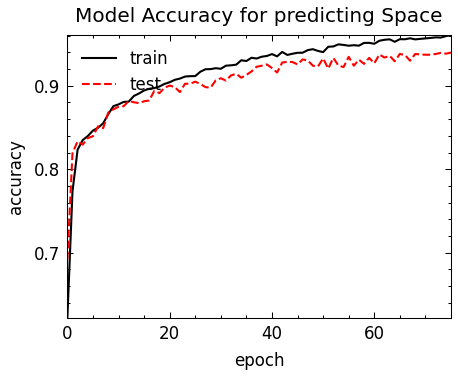

In [ ]:
pparam = dict(xlabel='epoch', ylabel='accuracy', title='Model Accuracy for predicting Space')

plt.style.reload_library()
plt.style.use(['science','no-latex'])
with plt.style.context(['science', 'ieee','no-latex']):
    fig, ax = plt.subplots(dpi=150)
    ax.plot(hist_rp.history['accuracy'], label='train')
    ax.plot(hist_rp.history['val_accuracy'], label='test')
    ax.legend(['train', 'test'], loc='upper left')
    ax.autoscale(tight=True)
    ax.set(**pparam)

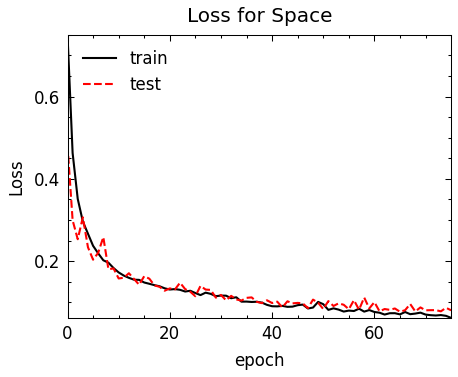

In [ ]:
pparam = dict(xlabel='epoch', ylabel='Loss', title='Loss for Space')

plt.style.reload_library()
plt.style.use(['science','no-latex'])
with plt.style.context(['science', 'ieee','no-latex']):
    fig, ax = plt.subplots(dpi=150)
    ax.plot(hist_rp.history['loss'], label='train')
    ax.plot(hist_rp.history['val_loss'], label='test')
    ax.legend(['train', 'test'], loc='upper left')
    ax.autoscale(tight=True)
    ax.set(**pparam)

#### CNN

In [ ]:
X5.shape, y5.shape

((19937, 523), (19937, 2))

In [ ]:
in_shp2 = np.reshape(X5, (19937,1,523,1))

In [ ]:
 X_train, X_test, y_train, y_test = train_test_split(in_shp2, y5, test_size=0.25, random_state=42)

In [ ]:
dr = 0.4 # dropout rate (%)
model_rpcnn = Sequential()
 
model_rpcnn.add(Conv2D(64, kernel_size=(1,5), strides=(1,1), input_shape=(1,523,1), activation="relu", name="conv1",))

model_rpcnn.add(MaxPooling2D(pool_size=(1,1)))
model_rpcnn.add(Flatten())
model_rpcnn.add(Dropout(dr))


model_rpcnn.add(Dense(300, name="dense1"))

model_rpcnn.add(Dense(150, name="dense2"))
#model.add(Flatten())
model_rpcnn.add(Dense(2,activation='softmax', name="dense3"))

model_rpcnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_rpcnn.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 1, 519, 64)        384       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 519, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 33216)             0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 33216)             0         
_________________________________________________________________
dense1 (Dense)               (None, 300)               9965100   
_________________________________________________________________
dense2 (Dense)               (None, 150)               45150     
_________________________________________________________________
dense3 (Dense)               (None, 2)               

In [ ]:
monitor3 = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')

In [ ]:
hist_rpcnn=model_rpcnn.fit(X_train,
    y_train,
    batch_size=1024,
    epochs=150,
    callbacks=[monitor3],
    verbose=1,
    validation_data=(X_test,y_test))

Epoch 1/150
15/15 [==============================] - 25s 2s/step - loss: 1.1904 - accuracy: 0.7866 - val_loss: 0.4637 - val_accuracy: 0.8257
Epoch 2/150
15/15 [==============================] - 25s 2s/step - loss: 0.3836 - accuracy: 0.8441 - val_loss: 0.3227 - val_accuracy: 0.8469
Epoch 3/150
15/15 [==============================] - 25s 2s/step - loss: 0.3213 - accuracy: 0.8585 - val_loss: 0.3076 - val_accuracy: 0.8582
Epoch 4/150
15/15 [==============================] - 25s 2s/step - loss: 0.3010 - accuracy: 0.8646 - val_loss: 0.2995 - val_accuracy: 0.8646
Epoch 5/150
15/15 [==============================] - 25s 2s/step - loss: 0.2900 - accuracy: 0.8699 - val_loss: 0.2941 - val_accuracy: 0.8686
Epoch 6/150
15/15 [==============================] - 25s 2s/step - loss: 0.2800 - accuracy: 0.8788 - val_loss: 0.2833 - val_accuracy: 0.8768
Epoch 7/150
15/15 [==============================] - 25s 2s/step - loss: 0.2692 - accuracy: 0.8846 - val_loss: 0.2768 - val_accuracy: 0.8806
Epoch 8/150
1

In [ ]:
pred = model_rpcnn.predict(X_test)

pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)


y_true= np.argmax(y_test,axis=1) 
sac3 = metrics.accuracy_score(y_true, pred)
print("Accuracy score: {}".format(sac3))

Accuracy score: 0.9125376128385155


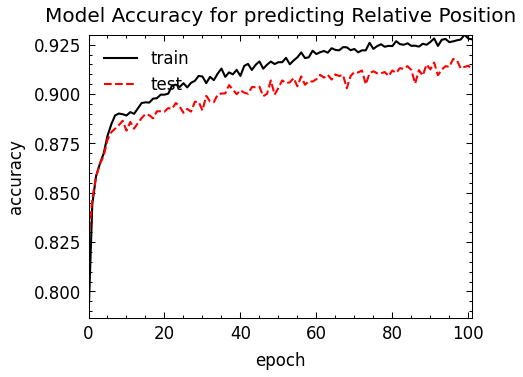

In [ ]:
pparam = dict(xlabel='epoch', ylabel='accuracy', title='Model Accuracy for predicting Relative Position')

plt.style.reload_library()
plt.style.use(['science','no-latex'])
with plt.style.context(['science', 'ieee','no-latex']):
    fig, ax = plt.subplots(dpi=150)
    ax.plot(hist_rpcnn.history['accuracy'], label='train')
    ax.plot(hist_rpcnn.history['val_accuracy'], label='test')
    ax.legend(['train', 'test'], loc='upper left')
    ax.autoscale(tight=True)
    ax.set(**pparam)

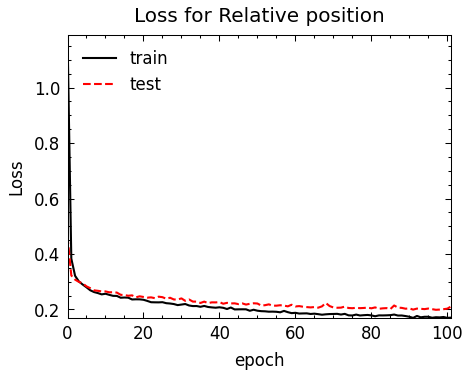

In [ ]:
pparam = dict(xlabel='epoch', ylabel='Loss', title='Loss for Relative position')

plt.style.reload_library()
plt.style.use(['science','no-latex'])
with plt.style.context(['science', 'ieee','no-latex']):
    fig, ax = plt.subplots(dpi=150)
    ax.plot(hist_rpcnn.history['loss'], label='train')
    ax.plot(hist_rpcnn.history['val_loss'], label='test')
    ax.legend(['train', 'test'], loc='upper left')
    ax.autoscale(tight=True)
    ax.set(**pparam)

In [ ]:
hist_rpcnn2=model_rpcnn.fit(X_train,
    y_train,
    batch_size=1000,
    epochs=400,
    callbacks=[monitor3],
    verbose=1,
    validation_data=(X_test,y_test))

Epoch 1/400
15/15 [==============================] - 25s 2s/step - loss: 0.1703 - accuracy: 0.9288 - val_loss: 0.2036 - val_accuracy: 0.9141
Epoch 2/400
15/15 [==============================] - 24s 2s/step - loss: 0.1701 - accuracy: 0.9251 - val_loss: 0.1988 - val_accuracy: 0.9168
Epoch 3/400
15/15 [==============================] - 24s 2s/step - loss: 0.1738 - accuracy: 0.9286 - val_loss: 0.1984 - val_accuracy: 0.9159
Epoch 4/400
15/15 [==============================] - 25s 2s/step - loss: 0.1692 - accuracy: 0.9268 - val_loss: 0.1997 - val_accuracy: 0.9174
Epoch 5/400
15/15 [==============================] - 24s 2s/step - loss: 0.1710 - accuracy: 0.9302 - val_loss: 0.1973 - val_accuracy: 0.9153
Epoch 6/400
15/15 [==============================] - 24s 2s/step - loss: 0.1683 - accuracy: 0.9284 - val_loss: 0.2017 - val_accuracy: 0.9157
Epoch 7/400
15/15 [==============================] - 25s 2s/step - loss: 0.1695 - accuracy: 0.9288 - val_loss: 0.1985 - val_accuracy: 0.9182
Epoch 8/400
1

In [ ]:
pred2 = model_rpcnn.predict(X_test)

pred2 = np.argmax(pred2,axis=1) # raw probabilities to choose class (highest probability)


y_true2= np.argmax(y_test,axis=1) 
sac4 = metrics.accuracy_score(y_true2, pred2)
print("Accuracy score: {}".format(sac4))

Accuracy score: 0.9137412236710131


#### LSTM


In [ ]:
SEQUENCE_SIZE = 1

#y5 is same as y_rp as we did sequences , y_rp is changed
x_rp,y_rp = to_sequences(SEQUENCE_SIZE,X,y5)

In [ ]:
x_rp.shape,y_rp.shape, y5.shape

((19936, 1, 1, 520), (19936, 2), (19937, 2))

In [ ]:
x_rp=np.reshape(x_rp,(19936,1,520))

In [ ]:
 X_trainls, X_testls, y_trainls, y_testls = train_test_split(x_rp, y_rp, test_size=0.25, random_state=33)

In [ ]:
modellsrp = Sequential()

modellsrp.add(LSTM(64,dropout=0.1, recurrent_dropout=0.1,  input_shape=(1,520),activation ='relu'))
modellsrp.add(Dense(400))
modellsrp.add(Dense(200))
modellsrp.add(Dense(2))



modellsrp.compile(loss='categorical_crossentropy', optimizer='adam')
modellsrp.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                149760    
_________________________________________________________________
dense_23 (Dense)             (None, 400)               26000     
_________________________________________________________________
dense_24 (Dense)             (None, 200)               80200     
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 402       
Total params: 256,362
Trainable params: 256,362
Non-trainable params: 0
_________________________________________________________________


In [ ]:
monitor4 = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')

modellsrp.fit(X_trainls,y_trainls,validation_data=(X_testls,y_testls), callbacks=[monitor4],verbose=2,epochs = 150)

Epoch 1/150
468/468 - 3s - loss: 0.8466 - val_loss: 0.4498
Epoch 2/150
468/468 - 3s - loss: 0.7324 - val_loss: 0.4247
Epoch 3/150
468/468 - 3s - loss: 0.4879 - val_loss: 0.5485
Epoch 4/150
468/468 - 3s - loss: 0.8198 - val_loss: 0.4016
Epoch 5/150
468/468 - 3s - loss: 0.8773 - val_loss: 1.1488
Epoch 6/150
468/468 - 3s - loss: 0.6285 - val_loss: 0.4775
Epoch 7/150
468/468 - 3s - loss: 0.4663 - val_loss: 0.4428
Epoch 8/150
468/468 - 3s - loss: 0.4565 - val_loss: 0.4349
Epoch 9/150
468/468 - 3s - loss: 0.4407 - val_loss: 0.4210
Epoch 10/150
468/468 - 3s - loss: 0.4190 - val_loss: 0.3832
Epoch 11/150
468/468 - 3s - loss: 0.3894 - val_loss: 0.3818
Epoch 12/150
468/468 - 3s - loss: 0.3737 - val_loss: 0.4121
Epoch 13/150
468/468 - 3s - loss: 0.5297 - val_loss: 0.4159
Epoch 14/150
468/468 - 3s - loss: 0.4624 - val_loss: 0.4176
Epoch 15/150
468/468 - 3s - loss: 0.4218 - val_loss: 0.4774
Epoch 16/150
468/468 - 3s - loss: 0.5565 - val_loss: 0.5385
Epoch 17/150
468/468 - 3s - loss: 0.4724 - val_lo

In [ ]:
X_testls.shape, X_trainls.shape

((4984, 1, 520), (14952, 1, 520))

In [ ]:
X_testls=np.reshape(X_testls,(4984,1,520))

In [ ]:
pred = modellsrp.predict(X_testls)

pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)


y_true= np.argmax(y_testls,axis=1) 
sac1 = metrics.accuracy_score(y_true, pred)
print("Accuracy score: {}".format(sac1))

Accuracy score: 0.1853932584269663


In [ ]:
monitor5 = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')

lstm_srp = modellsrp.fit(X_trainls,y_trainls,validation_data=(X_testls,y_testls), callbacks=[monitor5],verbose=2,epochs = 1000)

Epoch 1/1000
468/468 - 3s - loss: 0.4441 - val_loss: 0.4292
Epoch 2/1000
468/468 - 3s - loss: 0.4812 - val_loss: 0.5216
Epoch 3/1000
468/468 - 3s - loss: 0.4405 - val_loss: 0.4540
Epoch 4/1000
468/468 - 3s - loss: 0.5138 - val_loss: 0.5769
Epoch 5/1000
468/468 - 3s - loss: 0.5654 - val_loss: 0.4016
Epoch 6/1000
468/468 - 3s - loss: 0.3913 - val_loss: 0.5004
Epoch 7/1000
468/468 - 3s - loss: 0.6852 - val_loss: 0.7141
Epoch 8/1000
468/468 - 3s - loss: 0.5626 - val_loss: 0.4366
Epoch 9/1000
468/468 - 3s - loss: 0.5291 - val_loss: 0.5051
Epoch 10/1000
468/468 - 3s - loss: 0.4930 - val_loss: 0.5058
Epoch 11/1000
468/468 - 3s - loss: 0.4910 - val_loss: 0.4612
Epoch 12/1000
468/468 - 3s - loss: 0.4798 - val_loss: 0.4277
Epoch 13/1000
468/468 - 3s - loss: 0.4743 - val_loss: 0.4638
Epoch 14/1000
468/468 - 3s - loss: 0.7243 - val_loss: 0.7036
Epoch 15/1000
468/468 - 3s - loss: 0.4979 - val_loss: 0.4632
Epoch 00015: early stopping


In [ ]:
pred2 = modellsrp.predict(X_testls)

pred2 = np.argmax(pred2,axis=1) # raw probabilities to choose class (highest probability)


y_true2= np.argmax(y_testls,axis=1) 
sac2 = metrics.accuracy_score(y_true, pred2)
print("Accuracy score: {}".format(sac2))

Accuracy score: 0.44703049759229535


In [ ]:
lstm_srp.history

{'loss': [0.444110244512558,
  0.48117196559906006,
  0.44053778052330017,
  0.5138168334960938,
  0.5654175877571106,
  0.39128321409225464,
  0.6852138042449951,
  0.562635064125061,
  0.5291129946708679,
  0.4930025637149811,
  0.4910033643245697,
  0.4798491895198822,
  0.4743369221687317,
  0.7243357300758362,
  0.4979098439216614],
 'val_loss': [0.42923712730407715,
  0.5216192007064819,
  0.4539733827114105,
  0.5769079327583313,
  0.40155816078186035,
  0.5003712773323059,
  0.7141047716140747,
  0.43659961223602295,
  0.5050827860832214,
  0.5058216452598572,
  0.46120646595954895,
  0.42774778604507446,
  0.4637579917907715,
  0.7035567164421082,
  0.46316489577293396]}

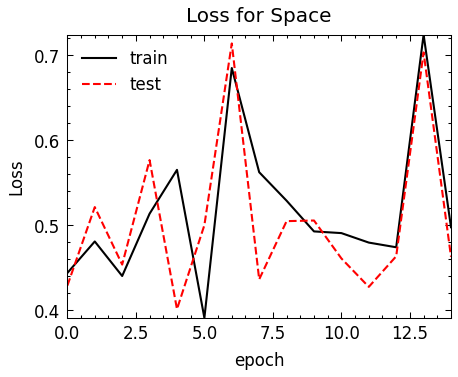

In [ ]:
pparam = dict(xlabel='epoch', ylabel='Loss', title='Loss for Space')

plt.style.reload_library()
plt.style.use(['science','no-latex'])
with plt.style.context(['science', 'ieee','no-latex']):
    fig, ax = plt.subplots(dpi=150)
    ax.plot(lstm_srp.history['loss'], label='train')
    ax.plot(lstm_srp.history['val_loss'], label='test')
    ax.legend(['train', 'test'], loc='upper left')
    ax.autoscale(tight=True)
    ax.set(**pparam)

#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor 
parameters = { "n_estimators" : [50, 100, 200], "max_depth": [100, 1000]}

random = RandomForestClassifier()

rfgridsearch = GridSearchCV(random, parameters,cv=3, verbose=5)
rfgridsearch.fit(X_train3, y_train3)
y_pred = rfgridsearch.predict(X_test3)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] max_depth=100, n_estimators=50 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... max_depth=100, n_estimators=50, score=0.960, total=   1.8s
[CV] max_depth=100, n_estimators=50 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] ...... max_depth=100, n_estimators=50, score=0.962, total=   1.7s
[CV] max_depth=100, n_estimators=50 ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] ...... max_depth=100, n_estimators=50, score=0.961, total=   1.8s
[CV] max_depth=100, n_estimators=100 .................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s


[CV] ..... max_depth=100, n_estimators=100, score=0.964, total=   3.4s
[CV] max_depth=100, n_estimators=100 .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.7s remaining:    0.0s


[CV] ..... max_depth=100, n_estimators=100, score=0.965, total=   3.4s
[CV] max_depth=100, n_estimators=100 .................................
[CV] ..... max_depth=100, n_estimators=100, score=0.963, total=   3.7s
[CV] max_depth=100, n_estimators=200 .................................
[CV] ..... max_depth=100, n_estimators=200, score=0.964, total=   7.5s
[CV] max_depth=100, n_estimators=200 .................................
[CV] ..... max_depth=100, n_estimators=200, score=0.967, total=   7.0s
[CV] max_depth=100, n_estimators=200 .................................
[CV] ..... max_depth=100, n_estimators=200, score=0.962, total=   6.9s
[CV] max_depth=1000, n_estimators=50 .................................
[CV] ..... max_depth=1000, n_estimators=50, score=0.962, total=   1.7s
[CV] max_depth=1000, n_estimators=50 .................................
[CV] ..... max_depth=1000, n_estimators=50, score=0.964, total=   1.8s
[CV] max_depth=1000, n_estimators=50 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.2min finished


Best parameters:  {'max_depth': 100, 'n_estimators': 200}
Accuracy score:  0.9736710130391174


In [ ]:
print('Best parameters: ', rfgridsearch.best_params_)
print('Accuracy score: ', format(accuracy_score(y_test3, y_pred)))

Best parameters:  {'max_depth': 100, 'n_estimators': 200}
Accuracy score:  0.9736710130391174


In [ ]:
from sklearn.ensemble import RandomForestClassifier 
parameters = { "n_estimators" : [100, 200], "max_depth": [100, 1000]}

random_rp = RandomForestClassifier()

rfgridsearch = GridSearchCV(random_rp, parameters,cv=3, verbose=5)
rfgridsearch.fit(x_train1, y_train1)
y_pred = rfgridsearch.predict(x_test1)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] max_depth=100, n_estimators=100 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ..... max_depth=100, n_estimators=100, score=0.958, total=   3.1s
[CV] max_depth=100, n_estimators=100 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ..... max_depth=100, n_estimators=100, score=0.954, total=   2.9s
[CV] max_depth=100, n_estimators=100 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ..... max_depth=100, n_estimators=100, score=0.954, total=   3.1s
[CV] max_depth=100, n_estimators=200 .................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.1s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ..... max_depth=100, n_estimators=200, score=0.958, total=   6.0s
[CV] max_depth=100, n_estimators=200 .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   15.1s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ..... max_depth=100, n_estimators=200, score=0.955, total=   5.9s
[CV] max_depth=100, n_estimators=200 .................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ..... max_depth=100, n_estimators=200, score=0.957, total=   6.0s
[CV] max_depth=1000, n_estimators=100 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .... max_depth=1000, n_estimators=100, score=0.958, total=   3.1s
[CV] max_depth=1000, n_estimators=100 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .... max_depth=1000, n_estimators=100, score=0.956, total=   3.0s
[CV] max_depth=1000, n_estimators=100 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .... max_depth=1000, n_estimators=100, score=0.956, total=   3.1s
[CV] max_depth=1000, n_estimators=200 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .... max_depth=1000, n_estimators=200, score=0.960, total=   6.0s
[CV] max_depth=1000, n_estimators=200 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .... max_depth=1000, n_estimators=200, score=0.953, total=   5.8s
[CV] max_depth=1000, n_estimators=200 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .... max_depth=1000, n_estimators=200, score=0.956, total=   6.1s


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   54.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [ ]:
print('Best parameters: ', rfgridsearch.best_params_)
print('Accuracy score: ', format(accuracy_score(y_test1, y_pred)))

Best parameters:  {'max_depth': 1000, 'n_estimators': 100}
Accuracy score:  0.9653961885656971


### **Predicting buildings**

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=33)

In [ ]:
#Predicting the model for buildings
start_time = time.time()
model_1 = Sequential()
model_1.add(Dense(150, input_dim=522, activation='relu'))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.4))
model_1.add(Dense(100, activation='relu'))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.4))
model_1.add(Dense(50, activation='relu'))
model_1.add(BatchNormalization())
model_1.add(Dense(3, activation='softmax'))
model_1.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])


model_1.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 150)               78450     
_________________________________________________________________
batch_normalization_12 (Batc (None, 150)               600       
_________________________________________________________________
dropout_15 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 100)               15100     
_________________________________________________________________
batch_normalization_13 (Batc (None, 100)               400       
_________________________________________________________________
dropout_16 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 50)              

In [ ]:
# Train the model
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, verbose=1, mode='auto')
model_build = model_1.fit(
    X_train1,
    y_train1,
    batch_size=900,
    epochs=100,
    callbacks=[monitor],
    shuffle=True,
    verbose=2,
    validation_data=(X_test1,y_test1)
)

predictions1 = np.round(model_1.predict(X_test1))


Epoch 1/100
18/18 - 1s - loss: 0.5418 - accuracy: 0.8069 - val_loss: 0.2838 - val_accuracy: 0.9895
Epoch 2/100
18/18 - 0s - loss: 0.0799 - accuracy: 0.9887 - val_loss: 0.0719 - val_accuracy: 0.9962
Epoch 3/100
18/18 - 0s - loss: 0.0351 - accuracy: 0.9944 - val_loss: 0.0298 - val_accuracy: 0.9967
Epoch 4/100
18/18 - 0s - loss: 0.0242 - accuracy: 0.9951 - val_loss: 0.0161 - val_accuracy: 0.9977
Epoch 5/100
18/18 - 0s - loss: 0.0187 - accuracy: 0.9960 - val_loss: 0.0101 - val_accuracy: 0.9977
Epoch 6/100
18/18 - 0s - loss: 0.0147 - accuracy: 0.9971 - val_loss: 0.0073 - val_accuracy: 0.9977
Epoch 7/100
18/18 - 0s - loss: 0.0133 - accuracy: 0.9969 - val_loss: 0.0054 - val_accuracy: 0.9977
Epoch 8/100
18/18 - 0s - loss: 0.0110 - accuracy: 0.9976 - val_loss: 0.0042 - val_accuracy: 0.9987
Epoch 9/100
18/18 - 0s - loss: 0.0086 - accuracy: 0.9981 - val_loss: 0.0037 - val_accuracy: 0.9987
Epoch 10/100
18/18 - 0s - loss: 0.0084 - accuracy: 0.9978 - val_loss: 0.0032 - val_accuracy: 0.9990
Epoch 11/

In [ ]:
# accuracy
print("Accuracy of predicting buildings = ",accuracy_score(y_test1,predictions1))

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

Accuracy of predicting buildings =  0.9994984954864594
--- Run time: 0.28 mins ---


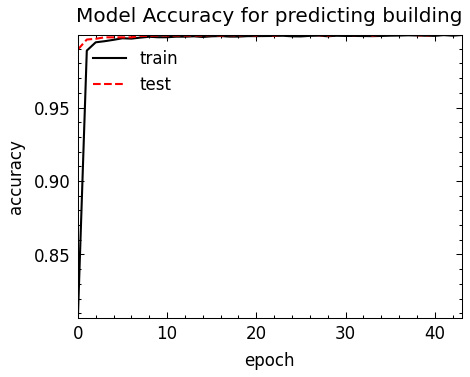

In [ ]:
pparam = dict(xlabel='epoch', ylabel='accuracy', title='Model Accuracy for predicting building')

plt.style.reload_library()
plt.style.use(['science','no-latex'])
with plt.style.context(['science', 'ieee','no-latex']):
    fig, ax = plt.subplots(dpi=150)
    ax.plot(model_build.history['accuracy'], label='train')
    ax.plot(model_build.history['val_accuracy'], label='test')
    ax.legend(['train', 'test'], loc='upper left')
    ax.autoscale(tight=True)
    ax.set(**pparam)

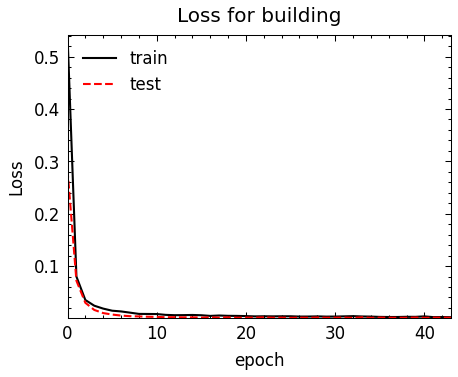

In [ ]:
pparam = dict(xlabel='epoch', ylabel='Loss', title='Loss for building')

plt.style.reload_library()
plt.style.use(['science','no-latex'])
with plt.style.context(['science', 'ieee','no-latex']):
    fig, ax = plt.subplots(dpi=150)
    ax.plot(model_build.history['loss'], label='train')
    ax.plot(model_build.history['val_loss'], label='test')
    ax.legend(['train', 'test'], loc='upper left')
    ax.autoscale(tight=True)
    ax.set(**pparam)



---



### **Thank you**


---


